# *TRAIN*

We need an appropiated structured dataframe to train the ML model. This dataframe must have a structure with the first column as SMILES, features, and the last column with inhibitory activity. 

From the ChEMBL database, we filter the cysteine protease targets and export them. We obtain 129 cystein protease targets and we will perform 4 model trainings. 

1. Train 1: No curated and no normalized data.
2. Train 2: Curated and no normalized data.
3. Train 3: Curated and z-score normalized data.
4. Train 4: Curated and MinMaxScaler normalized data. 

ChEMBL database:
https://www.ebi.ac.uk/chembl/

In [1]:
#Import packages
import pandas as pd
import requests

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors



In [2]:
#import pandas as pd

# Read CSV and create a dataframe
df_targets = pd.read_csv('../data/targets_cysteine_proteases_cheml.csv', sep = ";")

print(df_targets)

         ChEMBL ID                                      Name  \
0       CHEMBL5127             Poliovirus type 1 polyprotein   
1    CHEMBL2111357                                 Calpain 1   
2    CHEMBL3351205                               Peptidase 1   
3    CHEMBL1741213               Sentrin-specific protease 7   
4       CHEMBL3147                               Calpain 1/2   
..             ...                                       ...   
124     CHEMBL2323                               Cathepsin B   
125  CHEMBL3407323  Ubiquitin carboxyl-terminal hydrolase 10   
126  CHEMBL3407317        Ubl carboxyl-terminal hydrolase 18   
127     CHEMBL3776                                 Caspase-8   
128     CHEMBL3891                                 Calpain 1   

    UniProt Accessions             Type                    Organism  \
0               P03300   SINGLE PROTEIN  Human poliovirus 1 Mahoney   
1        P04632|P07384  PROTEIN COMPLEX                Homo sapiens   
2               P1

In [3]:
#Create a list with all the targetsID
targets_id = df_targets.iloc[:, 0].tolist()
print(targets_id)

['CHEMBL5127', 'CHEMBL2111357', 'CHEMBL3351205', 'CHEMBL1741213', 'CHEMBL3147', 'CHEMBL3612', 'CHEMBL1250372', 'CHEMBL2857', 'CHEMBL5801', 'CHEMBL1741221', 'CHEMBL1795087', 'CHEMBL1293295', 'CHEMBL4072', 'CHEMBL4779', 'CHEMBL1949492', 'CHEMBL2517', 'CHEMBL2069160', 'CHEMBL1909484', 'CHEMBL3559678', 'CHEMBL1075050', 'CHEMBL2157851', 'CHEMBL1075276', 'CHEMBL5832', 'CHEMBL1075277', 'CHEMBL3430905', 'CHEMBL2223', 'CHEMBL4097', 'CHEMBL4523939', 'CHEMBL3038466', 'CHEMBL5800', 'CHEMBL2157854', 'CHEMBL2205', 'CHEMBL1697672', 'CHEMBL1293227', 'CHEMBL3774301', 'CHEMBL5169181', 'CHEMBL3937', 'CHEMBL268', 'CHEMBL3563', 'CHEMBL5991', 'CHEMBL1250373', 'CHEMBL3349', 'CHEMBL3286062', 'CHEMBL3831289', 'CHEMBL3879833', 'CHEMBL4244', 'CHEMBL4295862', 'CHEMBL3407324', 'CHEMBL2954', 'CHEMBL2226', 'CHEMBL5037', 'CHEMBL2225', 'CHEMBL2034806', 'CHEMBL4295583', 'CHEMBL4742277', 'CHEMBL2176776', 'CHEMBL3232682', 'CHEMBL2111396', 'CHEMBL1697661', 'CHEMBL1250371', 'CHEMBL4620', 'CHEMBL2111441', 'CHEMBL1075185', '

We are using a list of known targets, and we have to find compounds that are active agains these targets. We will use a GitHub code to perform this.

https://gist.github.com/avrilcoghlan/531acff5f2f5860d5fc6631f549aec43

In [4]:
#import pandas as pd
#import requests

#join the targets into a suitable string to fulfil the search conditions for the API
targets = ",".join(targets_id)
assay_type = 'B' #only for Binding Assays
pchembl_value = 5 #Specify the minimum threshold of the pChEMBL activity value. 
limit = 100 #limit the number of records pulled back for each url call

url_stem = "https://www.ebi.ac.uk" #This is the stem of the url
url_full_string = url_stem + "/chembl/api/data/activity.json?target_chembl_id__in={}&assay_type={}&pchembl_value__gte=5&limit={}".format(targets, assay_type, limit) #This is the full url with the specified input parameters
url_full = requests.get( url_full_string ).json() #This calls the information back from the API using the 'requests' module, and converts it to json format
url_activities = url_full['activities'] #This is a list of the results for activities

#This 'while' loop iterates over several pages of records (if required), and collates the list of results
while url_full['page_meta']['next']:
    url_full = requests.get(url_stem + url_full['page_meta']['next']).json()
    url_activities = url_activities + url_full['activities'] #Add result (as a list) to previous list of results

#Convert the list of results into a Pandas dataframe:
act_df = pd.DataFrame(url_activities)

#Print out some useful information:
print("This is the url string that calls the 'Activities' API with the initial query specification:\n{}".format(url_full_string) )
print("\nThese are the available columns for the Activities API:\n{}".format(act_df.columns))

This is the url string that calls the 'Activities' API with the initial query specification:
https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__in=CHEMBL5127,CHEMBL2111357,CHEMBL3351205,CHEMBL1741213,CHEMBL3147,CHEMBL3612,CHEMBL1250372,CHEMBL2857,CHEMBL5801,CHEMBL1741221,CHEMBL1795087,CHEMBL1293295,CHEMBL4072,CHEMBL4779,CHEMBL1949492,CHEMBL2517,CHEMBL2069160,CHEMBL1909484,CHEMBL3559678,CHEMBL1075050,CHEMBL2157851,CHEMBL1075276,CHEMBL5832,CHEMBL1075277,CHEMBL3430905,CHEMBL2223,CHEMBL4097,CHEMBL4523939,CHEMBL3038466,CHEMBL5800,CHEMBL2157854,CHEMBL2205,CHEMBL1697672,CHEMBL1293227,CHEMBL3774301,CHEMBL5169181,CHEMBL3937,CHEMBL268,CHEMBL3563,CHEMBL5991,CHEMBL1250373,CHEMBL3349,CHEMBL3286062,CHEMBL3831289,CHEMBL3879833,CHEMBL4244,CHEMBL4295862,CHEMBL3407324,CHEMBL2954,CHEMBL2226,CHEMBL5037,CHEMBL2225,CHEMBL2034806,CHEMBL4295583,CHEMBL4742277,CHEMBL2176776,CHEMBL3232682,CHEMBL2111396,CHEMBL1697661,CHEMBL1250371,CHEMBL4620,CHEMBL2111441,CHEMBL1075185,CHEMBL4510,CHEMBL4751,CHE

We create the dataframe by selecting only the columns that interest us from all the information extracted from the database.

In [5]:
#Specify which columns to keep so that the size of the dataframe becomes more manageable:
act_df = act_df[[  'target_chembl_id','target_organism', 'target_pref_name'
                 , 'parent_molecule_chembl_id','molecule_chembl_id','molecule_pref_name'
                 , 'pchembl_value', 'standard_type','standard_relation', 'standard_value', 'standard_units'
                 , 'assay_chembl_id','document_chembl_id','src_id']]
act_df



target_chembl_id                                  target_organism  \
0           CHEMBL3563                                Trypanosoma cruzi   
1           CHEMBL2857                             Human rhinovirus sp.   
2           CHEMBL2857                             Human rhinovirus sp.   
3           CHEMBL4800                                     Mus musculus   
4           CHEMBL4620  Hepatitis C virus genotype 1a (isolate 1) (HCV)   
...                ...                                              ...   
19257        CHEMBL268                                     Homo sapiens   
19258        CHEMBL268                                     Homo sapiens   
19259        CHEMBL268                                     Homo sapiens   
19260        CHEMBL268                                     Homo sapiens   
19261        CHEMBL268                                     Homo sapiens   

                    target_pref_name parent_molecule_chembl_id  \
0                          Cruzipain               CHEMBL90512   
1        Human rhinovirus A protease               CHEMBL99102   
2        Human rhinovirus A protease              CHEMBL318278   
3                          Caspase-1               CHEMBL92017   
4      Hepatitis C virus polyprotein              CHEMBL276488   
...                              ...                       ...   
19257                    Cathepsin K              CHEMBL481611   
19258                    Cathepsin K             CHEMBL5220424   
19259                    Cathepsin K             CHEMBL5220960   
19260                    Cathepsin K             CHEMBL5219348   
19261                    Cathepsin K             CHEMBL5220975   

      molecule_chembl_id molecule_pref_name pchembl_value standard_type  \
0            CHEMBL90512               None          7.30          IC50   
1            CHEMBL99102               None          5.47          IC50   
2           CHEMBL318278               None          5.13          IC50   
3            CHEMBL92017               None          5.32          IC50   
4           CHEMBL276488               None          5.37          IC50   
...                  ...                ...           ...           ...   
19257       CHEMBL481611         ODANACATIB          8.77          IC50   
19258      CHEMBL5220424               None          6.01          IC50   
19259      CHEMBL5220960               None          7.21          IC50   
19260      CHEMBL5219348               None          6.63          IC50   
19261      CHEMBL5220975               None          6.45          IC50   

      standard_relation standard_value standard_units assay_chembl_id  \
0                     =           50.0             nM    CHEMBL660279   
1                     =         3400.0             nM    CHEMBL766325   
2                     =         7400.0             nM    CHEMBL766325   
3                     =         4800.0             nM    CHEMBL659308   
4                     =         4300.0             nM    CHEMBL857692   
...                 ...            ...            ...             ...   
19257                 =            1.7             nM   CHEMBL5217723   
19258                 =          974.3             nM   CHEMBL5217723   
19259                 =           61.9             nM   CHEMBL5217723   
19260                 =          235.2             nM   CHEMBL5217723   
19261                 =          356.4             nM   CHEMBL5217723   

      document_chembl_id  src_id  
0          CHEMBL1135476       1  
1          CHEMBL1131042       1  
2          CHEMBL1131042       1  
3          CHEMBL1131550       1  
4          CHEMBL1136650       1  
...                  ...     ...  
19257      CHEMBL5214986       1  
19258      CHEMBL5214986       1  
19259      CHEMBL5214986       1  
19260      CHEMBL5214986       1  
19261      CHEMBL5214986       1  

[19262 rows x 14 columns]

In [6]:
act_df["pchembl_value"] = act_df["pchembl_value"].astype(float)
act_df.sort_values(by="pchembl_value", ascending=False)
act_df


target_chembl_id                                  target_organism  \
0           CHEMBL3563                                Trypanosoma cruzi   
1           CHEMBL2857                             Human rhinovirus sp.   
2           CHEMBL2857                             Human rhinovirus sp.   
3           CHEMBL4800                                     Mus musculus   
4           CHEMBL4620  Hepatitis C virus genotype 1a (isolate 1) (HCV)   
...                ...                                              ...   
19257        CHEMBL268                                     Homo sapiens   
19258        CHEMBL268                                     Homo sapiens   
19259        CHEMBL268                                     Homo sapiens   
19260        CHEMBL268                                     Homo sapiens   
19261        CHEMBL268                                     Homo sapiens   

                    target_pref_name parent_molecule_chembl_id  \
0                          Cruzipain               CHEMBL90512   
1        Human rhinovirus A protease               CHEMBL99102   
2        Human rhinovirus A protease              CHEMBL318278   
3                          Caspase-1               CHEMBL92017   
4      Hepatitis C virus polyprotein              CHEMBL276488   
...                              ...                       ...   
19257                    Cathepsin K              CHEMBL481611   
19258                    Cathepsin K             CHEMBL5220424   
19259                    Cathepsin K             CHEMBL5220960   
19260                    Cathepsin K             CHEMBL5219348   
19261                    Cathepsin K             CHEMBL5220975   

      molecule_chembl_id molecule_pref_name  pchembl_value standard_type  \
0            CHEMBL90512               None           7.30          IC50   
1            CHEMBL99102               None           5.47          IC50   
2           CHEMBL318278               None           5.13          IC50   
3            CHEMBL92017               None           5.32          IC50   
4           CHEMBL276488               None           5.37          IC50   
...                  ...                ...            ...           ...   
19257       CHEMBL481611         ODANACATIB           8.77          IC50   
19258      CHEMBL5220424               None           6.01          IC50   
19259      CHEMBL5220960               None           7.21          IC50   
19260      CHEMBL5219348               None           6.63          IC50   
19261      CHEMBL5220975               None           6.45          IC50   

      standard_relation standard_value standard_units assay_chembl_id  \
0                     =           50.0             nM    CHEMBL660279   
1                     =         3400.0             nM    CHEMBL766325   
2                     =         7400.0             nM    CHEMBL766325   
3                     =         4800.0             nM    CHEMBL659308   
4                     =         4300.0             nM    CHEMBL857692   
...                 ...            ...            ...             ...   
19257                 =            1.7             nM   CHEMBL5217723   
19258                 =          974.3             nM   CHEMBL5217723   
19259                 =           61.9             nM   CHEMBL5217723   
19260                 =          235.2             nM   CHEMBL5217723   
19261                 =          356.4             nM   CHEMBL5217723   

      document_chembl_id  src_id  
0          CHEMBL1135476       1  
1          CHEMBL1131042       1  
2          CHEMBL1131042       1  
3          CHEMBL1131550       1  
4          CHEMBL1136650       1  
...                  ...     ...  
19257      CHEMBL5214986       1  
19258      CHEMBL5214986       1  
19259      CHEMBL5214986       1  
19260      CHEMBL5214986       1  
19261      CHEMBL5214986       1  

[19262 rows x 14 columns]

Extract the list of compounds from the previous dataframe, and call the molecule API to find their molecular properties.

In [8]:

! pip install chembl_webresource_client

Analisis del tipos de informació que conte la base de dades

In [7]:
#Obtain a list of unique ChEMBL ID and their SMILES

#First find the list of compounds that are within the act_df dataframe:
cmpd_chembl_ids = list(set(act_df['molecule_chembl_id']))
print("There are {} compounds initially identified as active on the known targets. e.g.".format(len(cmpd_chembl_ids)))

len2 = len(cmpd_chembl_ids) // 80
len2 = int(len2)
start = 0

df_total = pd.DataFrame()
for i in range(len(cmpd_chembl_ids)//len2):
    variable_name = "variable_" + str(i)
    globals()[variable_name] = cmpd_chembl_ids[i*len2:(i+1)*len2]

    globals()[variable_name] = ",".join(globals()[variable_name][0:])
    limit = 1500

    url_stem = "https://www.ebi.ac.uk" #This is the stem of the url
    url_full_string = url_stem + "/chembl/api/data/molecule.json?molecule_chembl_id__in={}&limit={}".format(globals()[variable_name], limit) #This is the full url with the specified input parameters
    #print(url_full_string)
    url_full = requests.get( url_full_string, timeout = 1000 ).json() #This calls the information back from the API using the 'requests' module, and converts it to json format
    url_molecules = url_full['molecules'] #This is a list of the results for activities

   
    while url_full['page_meta']['next']:
        url_full = requests.get(url_stem + url_full['page_meta']['next']).json()
        url_molecules = url_molecules + url_full['molecules'] #Add result (as a list) to previous list of results

    #Convert the list of results into a Pandas dataframe:
    mol_df = pd.DataFrame(url_molecules)

    #Select only relevant columns:
    mol_df = mol_df[[ 'molecule_chembl_id','molecule_structures']]
    
    mol_df['smiles'] = mol_df.loc[ mol_df['molecule_structures'].notnull(), 'molecule_structures'].apply(lambda x: x['canonical_smiles'])

    df_total = pd.concat([df_total, mol_df], ignore_index=True)

print(df_total)



There are 11140 compounds initially identified as active on the known targets. e.g.
      molecule_chembl_id                                molecule_structures  \
0           CHEMBL285320  {'canonical_smiles': 'CCCC(C(=O)N[C@@H](CC(=O)...   
1           CHEMBL282408  {'canonical_smiles': 'O=C(O)C[C@H](NC(=O)Cn1cc...   
2            CHEMBL30902  {'canonical_smiles': 'C=CCOC(=O)NC(CC(=O)O)C(=...   
3            CHEMBL41337  {'canonical_smiles': 'CCNC(=O)C(CC(C)C)NC(=O)[...   
4            CHEMBL61023  {'canonical_smiles': 'CC(=O)N[C@H](C(=O)N[C@@H...   
...                  ...                                                ...   
11115      CHEMBL5081719  {'canonical_smiles': 'CNCC(C(=O)N1CC2=C(C1)CN(...   
11116      CHEMBL5083364  {'canonical_smiles': 'O=S(=O)(c1ccc(-c2ncco2)c...   
11117      CHEMBL5094918  {'canonical_smiles': 'O=C(C(O)c1cccc(N2CCOCC2)...   
11118      CHEMBL5203694  {'canonical_smiles': 'CC(C)Cn1cc(-c2ccnc3[nH]c...   
11119      CHEMBL5206501  {'canonical_smiles': 

Analyze the SMILES that have null values and create a function that performs quality control of the SMILES, removing invalid ones, and save them in a new dataframe. 

In [8]:
df_total['smiles'].isna().sum()

8

In [9]:
#import pandas as pd
#from rdkit import Chem

def valid_smiles(smiles_list):
    ext_smiles = []

    for smiles in smiles_list:
        if isinstance(smiles, str):
            try:
                molecule = Chem.MolFromSmiles(smiles)
                if molecule is not None:
                    ext_smiles.append(Chem.MolToSmiles(molecule))
                else:
                    ext_smiles.append('nan')
            except Exception as e:
                ext_smiles.append('nan')
                pass

    return ext_smiles

smiles_list = df_total['smiles'].astype(str).tolist()

valid_smiles = valid_smiles(smiles_list)

# Crear un nuevo DataFrame con los SMILES extraídos
df_extracted = pd.DataFrame({'SMILES': valid_smiles})


print(df_extracted)


[19:54:58] SMILES Parse Error: syntax error while parsing: nan
[19:54:58] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:54:58] SMILES Parse Error: syntax error while parsing: nan
[19:54:58] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:54:59] SMILES Parse Error: syntax error while parsing: nan
[19:54:59] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:54:59] SMILES Parse Error: syntax error while parsing: nan
[19:54:59] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:00] SMILES Parse Error: syntax error while parsing: nan
[19:55:00] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:00] SMILES Parse Error: syntax error while parsing: nan
[19:55:00] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:02] SMILES Parse Error: syntax error while parsing: nan
[19:55:02] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:02] SMILES Parse Err

                                                  SMILES
0      CCCC(C(=O)N[C@@H](CC(=O)O)C(=O)COc1ccccc1)n1c(...
1      O=C(O)C[C@H](NC(=O)Cn1cccc(NC(=O)c2cccc3ccccc2...
2             C=CCOC(=O)NC(CC(=O)O)C(=O)COc1ccccc1C(N)=O
3      CCNC(=O)C(CC(C)C)NC(=O)[C@@H](CC(=O)C1c2ccccc2...
4      CC(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CC(=O...
...                                                  ...
11115  CNCC(C(=O)N1CC2=C(C1)CN(S(=O)(=O)c1ccc3c(c1)OC...
11116  O=S(=O)(c1ccc(-c2ncco2)cc1)N1Cc2cnc(C(O)c3cccc...
11117  O=C(C(O)c1cccc(N2CCOCC2)c1)N1CC2=C(C1)CN(S(=O)...
11118  CC(C)Cn1cc(-c2ccnc3[nH]c(C4CCN(CC(=O)N(C)C)CC4...
11119  C[C@H](NC(=O)[C@@H](c1cccnc1)N(C(=O)c1ccco1)c1...

[11120 rows x 1 columns]


In [10]:
df_total_na = df_total['smiles'].isna().sum()
print(df_total_na)

df_extracted_na = df_extracted['SMILES'].isna().sum()
print(df_extracted_na)

#Here we see that some of the SMILES we extracted initially were not captured correctly. Therefore, we will replace the 'smiles' column in df_total with the column from df_extracted where the SMILES have been recalculated.

8
0


In [11]:
df_total['smiles'] = df_extracted['SMILES']
df_total_na = df_total['smiles'].isna().sum()
print(df_total_na)

0


In [12]:
#verify the dimension of the data
print(df_total.shape)  
print(df_extracted.shape)  


(11120, 3)
(11120, 1)


In [13]:
#Create a dictionary to apply to act_df in order to add the SMILES from each molecule 

chembl_smiles_dict = dict(zip(df_total['molecule_chembl_id'], df_total['smiles']))

act_df['Smiles'] = act_df['molecule_chembl_id'].map(chembl_smiles_dict)

act_df

target_chembl_id                                  target_organism  \
0           CHEMBL3563                                Trypanosoma cruzi   
1           CHEMBL2857                             Human rhinovirus sp.   
2           CHEMBL2857                             Human rhinovirus sp.   
3           CHEMBL4800                                     Mus musculus   
4           CHEMBL4620  Hepatitis C virus genotype 1a (isolate 1) (HCV)   
...                ...                                              ...   
19257        CHEMBL268                                     Homo sapiens   
19258        CHEMBL268                                     Homo sapiens   
19259        CHEMBL268                                     Homo sapiens   
19260        CHEMBL268                                     Homo sapiens   
19261        CHEMBL268                                     Homo sapiens   

                    target_pref_name parent_molecule_chembl_id  \
0                          Cruzipain               CHEMBL90512   
1        Human rhinovirus A protease               CHEMBL99102   
2        Human rhinovirus A protease              CHEMBL318278   
3                          Caspase-1               CHEMBL92017   
4      Hepatitis C virus polyprotein              CHEMBL276488   
...                              ...                       ...   
19257                    Cathepsin K              CHEMBL481611   
19258                    Cathepsin K             CHEMBL5220424   
19259                    Cathepsin K             CHEMBL5220960   
19260                    Cathepsin K             CHEMBL5219348   
19261                    Cathepsin K             CHEMBL5220975   

      molecule_chembl_id molecule_pref_name  pchembl_value standard_type  \
0            CHEMBL90512               None           7.30          IC50   
1            CHEMBL99102               None           5.47          IC50   
2           CHEMBL318278               None           5.13          IC50   
3            CHEMBL92017               None           5.32          IC50   
4           CHEMBL276488               None           5.37          IC50   
...                  ...                ...            ...           ...   
19257       CHEMBL481611         ODANACATIB           8.77          IC50   
19258      CHEMBL5220424               None           6.01          IC50   
19259      CHEMBL5220960               None           7.21          IC50   
19260      CHEMBL5219348               None           6.63          IC50   
19261      CHEMBL5220975               None           6.45          IC50   

      standard_relation standard_value standard_units assay_chembl_id  \
0                     =           50.0             nM    CHEMBL660279   
1                     =         3400.0             nM    CHEMBL766325   
2                     =         7400.0             nM    CHEMBL766325   
3                     =         4800.0             nM    CHEMBL659308   
4                     =         4300.0             nM    CHEMBL857692   
...                 ...            ...            ...             ...   
19257                 =            1.7             nM   CHEMBL5217723   
19258                 =          974.3             nM   CHEMBL5217723   
19259                 =           61.9             nM   CHEMBL5217723   
19260                 =          235.2             nM   CHEMBL5217723   
19261                 =          356.4             nM   CHEMBL5217723   

      document_chembl_id  src_id  \
0          CHEMBL1135476       1   
1          CHEMBL1131042       1   
2          CHEMBL1131042       1   
3          CHEMBL1131550       1   
4          CHEMBL1136650       1   
...                  ...     ...   
19257      CHEMBL5214986       1   
19258      CHEMBL5214986       1   
19259      CHEMBL5214986       1   
19260      CHEMBL5214986       1   
19261      CHEMBL5214986       1   

                                                  Smiles  
0                       C/C(=N

In [14]:
act_df.columns

Index(['target_chembl_id', 'target_organism', 'target_pref_name',
       'parent_molecule_chembl_id', 'molecule_chembl_id', 'molecule_pref_name',
       'pchembl_value', 'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'assay_chembl_id', 'document_chembl_id', 'src_id',
       'Smiles'],
      dtype='object')

## DATA ANALYSIS
### 1. TARGET ANALYSIS

In [23]:
#Single targets

uniq_target = act_df['target_pref_name'].nunique()

print('From', len(act_df['target_pref_name']), 'there are', uniq_target, 'different targets')

From 19262 there are 70 different targets


In [24]:
cont_targ = act_df['target_pref_name'].value_counts()
cont_targ

Cathepsin S                                 2510
Cathepsin K                                 2158
Cathepsin L                                 1812
Protease                                    1391
Cathepsin B                                 1276
                                            ... 
Caspase                                        1
Dipeptidyl peptidase 1                         1
Ubiquitin carboxyl-terminal hydrolase 13       1
Poliovirus type 1 polyprotein                  1
Cysteine protease ATG4A                        1
Name: target_pref_name, Length: 70, dtype: int64

The most frequent category: Cathepsin S (2510)


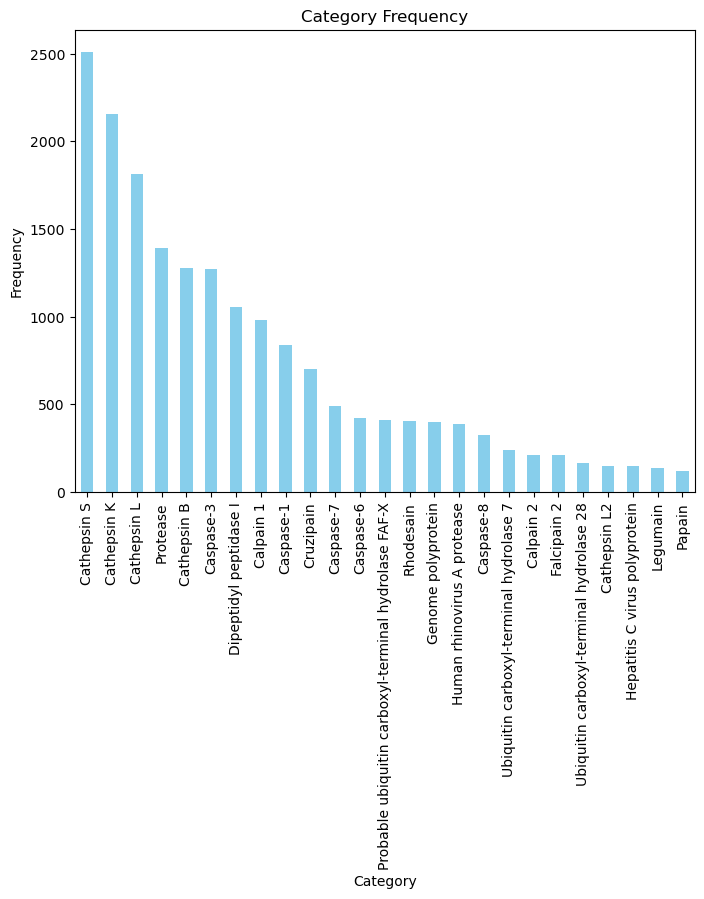

In [25]:
# Calculate the frequency of each category
frequency = act_df['target_pref_name'].value_counts()

# Define a minimum frequency threshold
threshold_freq = 100 

# Filter out categories that exceed the threshold
categories_freq = frequency[frequency >= threshold_freq]

# Barplot
plt.figure(figsize=(8, 6))
categories_freq.plot(kind='bar', color='skyblue')
plt.title('Category Frequency')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# Find the most frequent category
category_more_freq = categories_freq.idxmax()
frequency_more_freq = categories_freq.max()
print(f'The most frequent category: {category_more_freq} ({frequency_more_freq})')

# Save the plot
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/train_freq_categories.png', bbox_inches='tight', dpi=300)

# Show
plt.show()

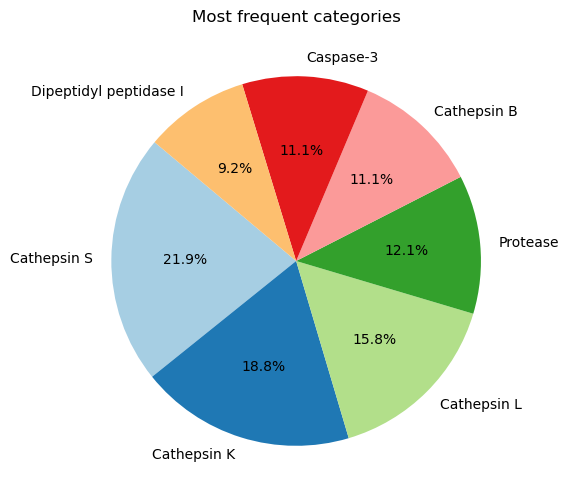

In [26]:
# Threshold
threshold_freq = 1000  

categories_freq = frequency[frequency >= threshold_freq]

# pie chart
plt.figure(figsize=(8, 6))
plt.pie(categories_freq, labels=categories_freq.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(categories_freq))))
plt.title('Most frequent categories')

# Save the plot
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/train_piechart_freq_categories.png', bbox_inches='tight', dpi=300)

# Show
plt.show()

In [27]:
#import pandas as pd


obj = ['Cathepsin S', 'Cathepsin K', 'Cathepsin L']
df_filtr_category = act_df[act_df['target_pref_name'].isin(obj)]

print(df_filtr_category[['target_pref_name', 'pchembl_value']])

      target_pref_name  pchembl_value
108        Cathepsin S           7.29
109        Cathepsin S           8.40
110        Cathepsin S           8.05
111        Cathepsin S           9.00
112        Cathepsin S           7.33
...                ...            ...
19257      Cathepsin K           8.77
19258      Cathepsin K           6.01
19259      Cathepsin K           7.21
19260      Cathepsin K           6.63
19261      Cathepsin K           6.45

[6480 rows x 2 columns]


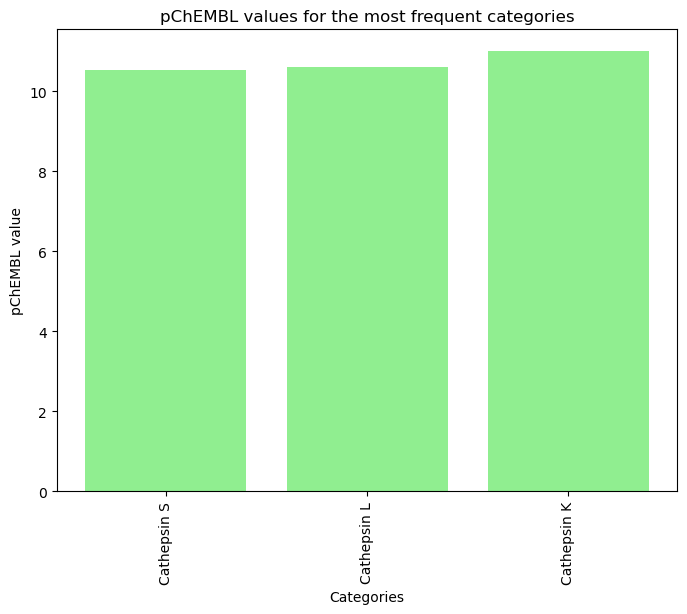

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(df_filtr_category['target_pref_name'], df_filtr_category['pchembl_value'], color='lightgreen')
plt.title('pChEMBL values for the most frequent categories')
plt.xlabel('Categories')
plt.ylabel('pChEMBL value')
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/train_barplot_freq_category.png', bbox_inches='tight', dpi=300)

# Mostrar el gráfico de barras
plt.show()

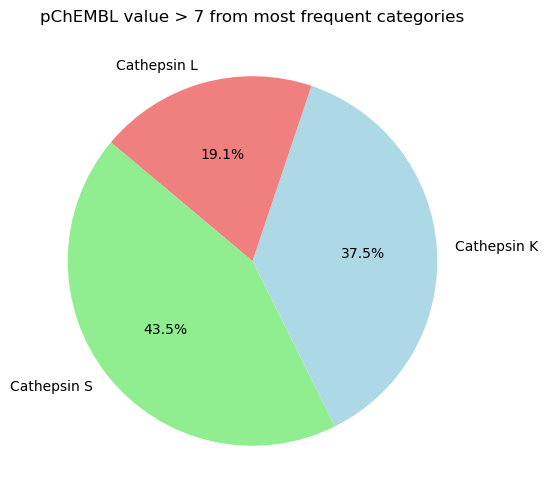

In [29]:

S_threshold = df_filtr_category[(df_filtr_category['target_pref_name'] == 'Cathepsin S') & (df_filtr_category['pchembl_value'] > 7)]
K_threshold= df_filtr_category[(df_filtr_category['target_pref_name'] == 'Cathepsin K') & (df_filtr_category['pchembl_value'] > 7)]
L_threshold = df_filtr_category[(df_filtr_category['target_pref_name'] == 'Cathepsin L') & (df_filtr_category['pchembl_value'] > 7)]


qty_S_threshold = len(S_threshold)
qty_K_threshold= len(K_threshold)
qty_L_threshold = len(L_threshold)

plt.figure(figsize=(8, 6))
plt.pie([qty_S_threshold, qty_K_threshold, qty_L_threshold],
        labels=['Cathepsin S', 'Cathepsin K', 'Cathepsin L'],
        autopct='%1.1f%%',
        colors=['lightgreen', 'lightblue', 'lightcoral'],
        startangle=140)
plt.title('pChEMBL value > 7 from most frequent categories')

plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/train_piechart_most_freq_category.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
#Targets interaction with components
#import pandas as pd

tabla_inter = act_df.groupby('target_pref_name')['molecule_chembl_id'].apply(list).reset_index()
tabla_inter.columns = ['Target', 'Component']

print(tabla_inter)

                                              Target  \
0                                          Calpain 1   
1                                        Calpain 1/2   
2                                          Calpain 2   
3                            Calpain small subunit 1   
4                                         Calpain1/2   
..                                               ...   
65           Ubiquitin carboxyl-terminal hydrolase 5   
66           Ubiquitin carboxyl-terminal hydrolase 7   
67           Ubiquitin carboxyl-terminal hydrolase 8   
68  Ubiquitin carboxyl-terminal hydrolase isozyme L1   
69  Ubiquitin carboxyl-terminal hydrolase isozyme L3   

                                            Component  
0   [CHEMBL169598, CHEMBL433914, CHEMBL169230, CHE...  
1                         [CHEMBL423112, CHEMBL32059]  
2   [CHEMBL324834, CHEMBL115426, CHEMBL116746, CHE...  
3   [CHEMBL416281, CHEMBL432121, CHEMBL301598, CHE...  
4       [CHEMBL2402203, CHEMBL4590201, CHEMBL45

In [ ]:
tabla_inter

Target  \
0                                          Calpain 1   
1                                        Calpain 1/2   
2                                          Calpain 2   
3                            Calpain small subunit 1   
4                                         Calpain1/2   
..                                               ...   
65           Ubiquitin carboxyl-terminal hydrolase 5   
66           Ubiquitin carboxyl-terminal hydrolase 7   
67           Ubiquitin carboxyl-terminal hydrolase 8   
68  Ubiquitin carboxyl-terminal hydrolase isozyme L1   
69  Ubiquitin carboxyl-terminal hydrolase isozyme L3   

                                            Component  
0   [CHEMBL169598, CHEMBL433914, CHEMBL169230, CHE...  
1                         [CHEMBL423112, CHEMBL32059]  
2   [CHEMBL324834, CHEMBL115426, CHEMBL116746, CHE...  
3   [CHEMBL416281, CHEMBL432121, CHEMBL301598, CHE...  
4       [CHEMBL2402203, CHEMBL4590201, CHEMBL4520267]  
..                                                ...  
65      [CHEMBL2012938, CHEMBL2012938, CHEMBL1923233]  
66  [CHEMBL2159495, CHEMBL2159497, CHEMBL2159498, ...  
67  [CHEMBL2398212, CHEMBL5172138, CHEMBL5196686, ...  
68  [CHEMBL541136, CHEMBL537225, CHEMBL540117, CHE...  
69  [CHEMBL1241028, CHEMBL1397260, CHEMBL5193983, ...  

[70 rows x 2 columns]

### 2. ORGANISM ANALYSIS

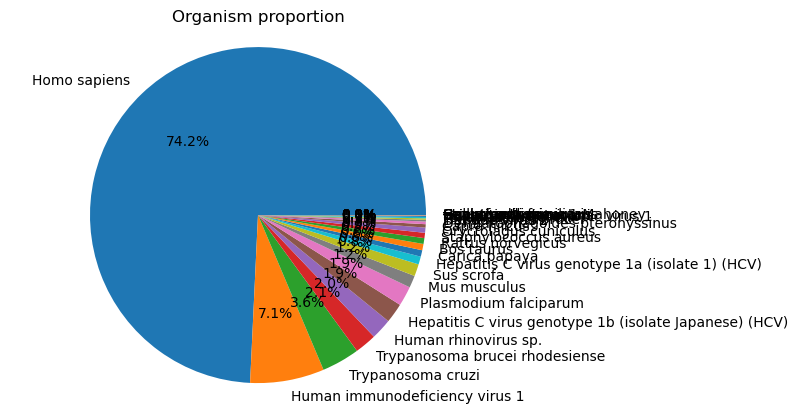

In [30]:
#import matplotlib.pyplot as plt

# Frequency of each organism
freq_org = act_df['target_organism'].value_counts()

# Pie chart
plt.pie(freq_org.values, labels=freq_org.index, autopct='%1.1f%%')
plt.title('Organism proportion')
plt.axis('equal')
plt.show()


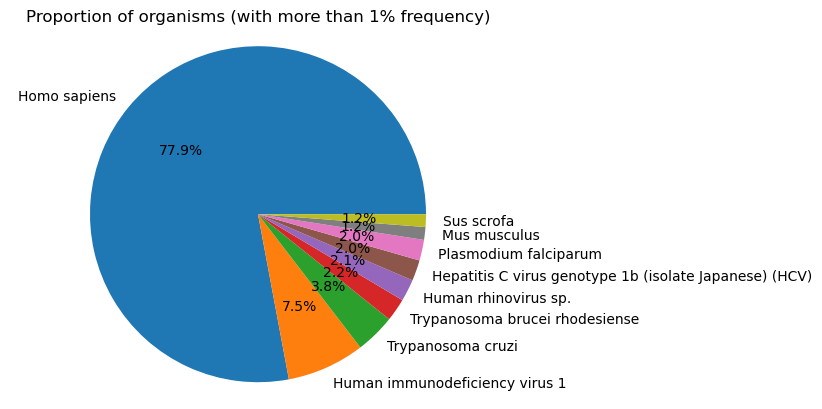

In [31]:
#Organisms with more than 1% of frequency

#import matplotlib.pyplot as plt

freq_org = act_df['target_organism'].value_counts()

# Percentage
percent_org = freq_org / len(act_df) * 100

# Filter with more than 1%
org_filtrados = percent_org[percent_org > 1]

# Crear el gráfico de pastel
plt.pie(org_filtrados.values, labels=org_filtrados.index, autopct='%1.1f%%')
plt.title('Proportion of organisms (with more than 1% frequency)')
plt.axis('equal')
plt.show()


In [20]:
# Encuentra los valores duplicados en la columna 'smiles'
duplicated_smiles = act_df[act_df['Smiles'].duplicated()]['Smiles'].unique()

if len(duplicated_smiles) > 0:
    print("Valores de SMILES duplicados:")
    for smile in duplicated_smiles:
        print(smile)
else:
    print("No se encontraron valores de SMILES duplicados.")

Valores de SMILES duplicados:
CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@H](C(=O)N[C@H]1CC(=O)OC1O)C(C)C
CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@H]1CC(=O)OC1O)C(C)C
CC(C)C[C@H](C=O)NC(=O)[C@@H](NS(=O)(=O)c1ccc(F)cc1)C(C)C
CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N1CCCC[C@H]1C(=O)N[C@H]1CC(=O)OC1O
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)c1ccccc1
N#C[C@@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1)c1ccccc1
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)CCc1ccccc1
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)Cc1ccc(Cl)c(Cl)c1
CC(C)(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)COCc1ccccc1
N#C[C@H](COCc1ccccc1Cl)NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1
CC(C)(C#N)NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)COCc1ccccc1
CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)COCc1ccc(Cl)cc1
N#C[C@H](CCc1ccccc1)NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1
N#C[C@H](COCc1ccccc1)NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1
CC(C)CC[C@H](NC(=O)N1CCOCC1)C(=O)N[C@@H](C#N)CCc1ccccc1
CC(C)[C@H

In [34]:
# Frequency of organisms
freq_org = act_df['target_organism'].value_counts(normalize=True)

# Identificar los organismos que tienen más del 1% de frecuencia
org_more_freq = freq_org[freq_org > 0.01].index

# Crear un nuevo DataFrame con las filas seleccionadas
df_organism = act_df[act_df['target_organism'].isin(org_more_freq)]
print(df_organism)

      target_chembl_id       target_organism             target_pref_name  \
0           CHEMBL3563     Trypanosoma cruzi                    Cruzipain   
1           CHEMBL2857  Human rhinovirus sp.  Human rhinovirus A protease   
2           CHEMBL2857  Human rhinovirus sp.  Human rhinovirus A protease   
3           CHEMBL4800          Mus musculus                    Caspase-1   
5           CHEMBL3563     Trypanosoma cruzi                    Cruzipain   
...                ...                   ...                          ...   
19257        CHEMBL268          Homo sapiens                  Cathepsin K   
19258        CHEMBL268          Homo sapiens                  Cathepsin K   
19259        CHEMBL268          Homo sapiens                  Cathepsin K   
19260        CHEMBL268          Homo sapiens                  Cathepsin K   
19261        CHEMBL268          Homo sapiens                  Cathepsin K   

      parent_molecule_chembl_id molecule_chembl_id molecule_pref_name  \
0 

In [35]:
type_org = df_organism['target_organism'].unique()

print(len(type_org), type_org)

9 ['Trypanosoma cruzi' 'Human rhinovirus sp.' 'Mus musculus' 'Homo sapiens'
 'Sus scrofa' 'Plasmodium falciparum' 'Trypanosoma brucei rhodesiense'
 'Human immunodeficiency virus 1'
 'Hepatitis C virus genotype 1b (isolate Japanese) (HCV)']


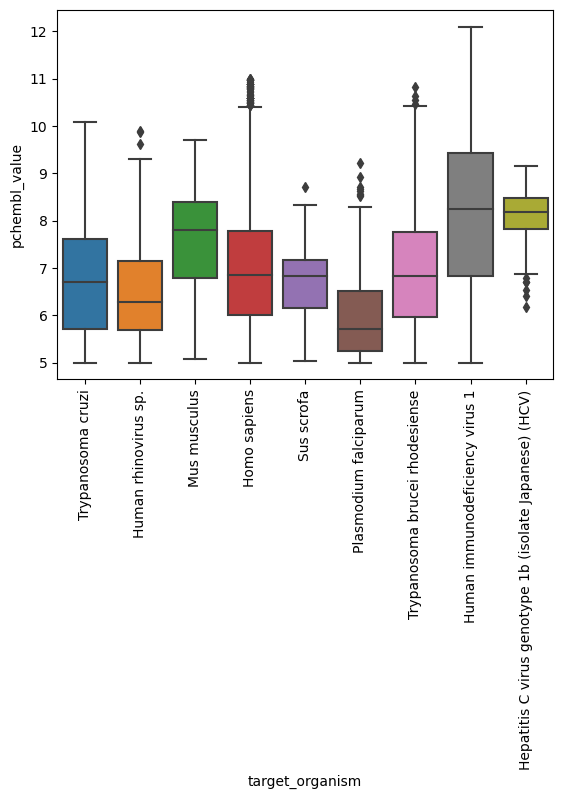

In [36]:
#import seaborn as sns
#import matplotlib.pyplot as plt

sns.boxplot(data=df_organism, x='target_organism', y='pchembl_value')
plt.xticks(rotation=90)

plt.show()

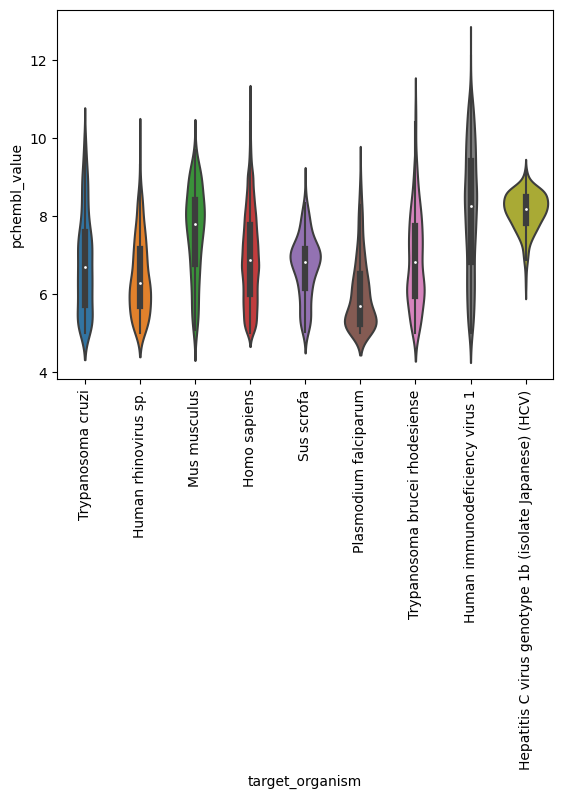

In [37]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Violinplot
sns.violinplot(x='target_organism', y='pchembl_value', data=df_organism)


plt.xticks(rotation=90)

plt.show()

In [38]:
#import pandas as pd

# Create a dictionary to associate SMILES and organisms
dic_smile_organism = dict(zip(act_df['Smiles'], act_df['target_organism']))


In [110]:
%store dic_smile_organism

Stored 'dic_smile_organism' (dict)


In [39]:
#Targets with highest pvalue
max_group = act_df.groupby('target_pref_name')['pchembl_value'].max()
max_group

target_pref_name
Calpain 1                                           8.70
Calpain 1/2                                         8.00
Calpain 2                                           8.30
Calpain small subunit 1                             8.33
Calpain1/2                                          7.02
                                                    ... 
Ubiquitin carboxyl-terminal hydrolase 5             5.52
Ubiquitin carboxyl-terminal hydrolase 7             9.80
Ubiquitin carboxyl-terminal hydrolase 8             9.55
Ubiquitin carboxyl-terminal hydrolase isozyme L1    6.64
Ubiquitin carboxyl-terminal hydrolase isozyme L3    7.30
Name: pchembl_value, Length: 70, dtype: float64

Anem a mirar la relació pchembl_value amb el codi chembl.
Per treballar amb menys dades, seleccionem les que tenen un valor igual o més gran a 7 de logIC50. 

In [112]:
# Filtrar los resultados con pchembl_value significativo
sig_res_chembl = act_df[act_df['pchembl_value'] >= 7.0].copy()

# Mostrar el nuevo DataFrame con resultados significativos
print(sig_res_chembl)

      target_chembl_id    target_organism        target_pref_name  \
0           CHEMBL3563  Trypanosoma cruzi               Cruzipain   
6           CHEMBL3891       Homo sapiens               Calpain 1   
9           CHEMBL3891       Homo sapiens               Calpain 1   
12          CHEMBL3563  Trypanosoma cruzi               Cruzipain   
14          CHEMBL3563  Trypanosoma cruzi               Cruzipain   
...                ...                ...                     ...   
19239       CHEMBL2252       Homo sapiens  Dipeptidyl peptidase I   
19255       CHEMBL3563  Trypanosoma cruzi               Cruzipain   
19256       CHEMBL3563  Trypanosoma cruzi               Cruzipain   
19257        CHEMBL268       Homo sapiens             Cathepsin K   
19259        CHEMBL268       Homo sapiens             Cathepsin K   

      parent_molecule_chembl_id molecule_chembl_id molecule_pref_name  \
0                   CHEMBL90512        CHEMBL90512               None   
6                  CHEMBL

## 2. CONSTRUCTION OF STRUCTURE TRAINING SET

**RDKIT:**

We will add the following features with RDKIT:

* Molecular weight: 

* LogP

* Number hydrogen acceptors

* Number hydrogen donors

* Rotatable bonds

* TPSA

* Number of rings

* Number of heavy atoms

* Fraction CSP3
 
* Balaban J Index


FALTA EXPLICAR!!!



In [15]:
df_train = act_df.loc[:, ['Smiles', 'target_chembl_id', 'target_pref_name', 'molecule_chembl_id', 'pchembl_value']]
df_train

Smiles target_chembl_id  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1       CHEMBL3563   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1       CHEMBL2857   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1       CHEMBL2857   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...       CHEMBL4800   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...       CHEMBL4620   
...                                                  ...              ...   
19257  CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(S(C)(=O)=O...        CHEMBL268   
19258             CC(C)(C)CN(Cc1ccc(Br)cc1)c1nccc(C#N)n1        CHEMBL268   
19259    CN1CCN(c2ccc(CN(CC(C)(C)C)c3nccc(C#N)n3)cc2)CC1        CHEMBL268   
19260      CC(C)(C)CN(Cc1ccc(-c2ccccc2)cc1)c1nccc(C#N)n1        CHEMBL268   
19261           CC(C)(C)CN(Cc1ccc2ccccc2c1)c1nccc(C#N)n1        CHEMBL268   

                    target_pref_name molecule_chembl_id  pchembl_value  
0                          Cruzipain        CHEMBL90512           7.30  
1        Human rhinovirus A protease        CHEMBL99102           5.47  
2        Human rhinovirus A protease       CHEMBL318278           5.13  
3                          Caspase-1        CHEMBL92017           5.32  
4      Hepatitis C virus polyprotein       CHEMBL276488           5.37  
...                              ...                ...            ...  
19257                    Cathepsin K       CHEMBL481611           8.77  
19258                    Cathepsin K      CHEMBL5220424           6.01  
19259                    Cathepsin K      CHEMBL5220960           7.21  
19260                    Cathepsin K      CHEMBL5219348           6.63  
19261                    Cathepsin K      CHEMBL5220975           6.45  

[19262 rows x 5 columns]

With a function using rdkit, create a dataframe with features

In [16]:
#from rdkit import Chem
#from rdkit.Chem import Crippen, Descriptors


def calc_feat(df,columna):
    data_c = []
    for smile in df[columna]:
        if pd.notna(smile): #saltem els que te smile na
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                hba_num = Descriptors.NumHAcceptors(mol)
                hbd_num = Descriptors.NumHDonors(mol)
                rotb_num = Descriptors.NumRotatableBonds(mol)
                tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
                ring_num = Chem.Descriptors.RingCount(mol)
                ha_num = Chem.Descriptors.HeavyAtomCount(mol)
                csp3 = Chem.Descriptors.FractionCSP3(mol)
                bji = Chem.Descriptors.BalabanJ(mol)

                data_c.append([mw,logp,hbd_num,hba_num,rotb_num,tpsa,ring_num,ha_num,csp3,bji])
    return data_c


data_c = calc_feat(df_train, 'Smiles')
data_c

df_result_feat= pd.DataFrame(data_c,columns=['MW','logP',"H-bond donor","H-bond acceptor","Rotatable bonds", "TPSA", "Ring counts", "Heavy atoms counts", "Fraction CSP3", "Balaban J Index"])


[19:55:56] SMILES Parse Error: syntax error while parsing: nan
[19:55:56] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:56] SMILES Parse Error: syntax error while parsing: nan
[19:55:56] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:55:56] SMILES Parse Error: syntax error while parsing: nan
[19:55:56] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:56:03] SMILES Parse Error: syntax error while parsing: nan
[19:56:03] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:56:03] SMILES Parse Error: syntax error while parsing: nan
[19:56:03] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:56:08] SMILES Parse Error: syntax error while parsing: nan
[19:56:08] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:56:08] SMILES Parse Error: syntax error while parsing: nan
[19:56:08] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[19:56:08] SMILES Parse Err

In [17]:
#Order the dataframe 

df_train_chemp = pd.concat([df_train, df_result_feat], axis=1)

activity = df_train_chemp.pop('pchembl_value')

df_train_chemp['pchembl_value'] = activity

df_train_chemp

Smiles target_chembl_id  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1       CHEMBL3563   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1       CHEMBL2857   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1       CHEMBL2857   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...       CHEMBL4800   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...       CHEMBL4620   
...                                                  ...              ...   
19257  CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(S(C)(=O)=O...        CHEMBL268   
19258             CC(C)(C)CN(Cc1ccc(Br)cc1)c1nccc(C#N)n1        CHEMBL268   
19259    CN1CCN(c2ccc(CN(CC(C)(C)C)c3nccc(C#N)n3)cc2)CC1        CHEMBL268   
19260      CC(C)(C)CN(Cc1ccc(-c2ccccc2)cc1)c1nccc(C#N)n1        CHEMBL268   
19261           CC(C)(C)CN(Cc1ccc2ccccc2c1)c1nccc(C#N)n1        CHEMBL268   

                    target_pref_name molecule_chembl_id       MW    logP  \
0                          Cruzipain        CHEMBL90512  262.165  2.9619   
1        Human rhinovirus A protease        CHEMBL99102  336.435  4.0810   
2        Human rhinovirus A protease       CHEMBL318278  338.407  3.0906   
3                          Caspase-1        CHEMBL92017  449.485  0.0954   
4      Hepatitis C virus polyprotein       CHEMBL276488  672.828  0.6726   
...                              ...                ...      ...     ...   
19257                    Cathepsin K       CHEMBL481611      NaN     NaN   
19258                    Cathepsin K      CHEMBL5220424      NaN     NaN   
19259                    Cathepsin K      CHEMBL5220960      NaN     NaN   
19260                    Cathepsin K      CHEMBL5219348      NaN     NaN   
19261                    Cathepsin K      CHEMBL5220975      NaN     NaN   

       H-bond donor  H-bond acceptor  Rotatable bonds    TPSA  Ring counts  \
0               2.0              2.0              2.0   50.74          1.0   
1               1.0              2.0              6.0   49.41          3.0   
2               0.0              3.0              5.0   49.85          3.0   
3               3.0              8.0              5.0  134.27          4.0   
4               6.0              9.0             19.0  231.44          2.0   
...             ...              ...              ...     ...          ...   
19257           NaN              NaN              NaN     NaN          NaN   
19258           NaN              NaN              NaN     NaN          NaN   
19259           NaN              NaN              NaN     NaN          NaN   
19260           NaN              NaN              NaN     NaN          NaN   
19261           NaN              NaN              NaN     NaN          NaN   

       Heavy atoms counts  Fraction CSP3  Balaban J Index  pchembl_value  
0                    15.0       0.111111         3.015937           7.30  
1                    25.0       0.333333         1.665537           5.47  
2                    25.0       0.300000         1.621866           5.13  
3                    31.0       0.500000         1.333796           5.32  
4                    48.0       0.666667         2.267243           5.37  
...                   ...            ...              ...            ...  
19257                 NaN            NaN              NaN           8.77  
19258                 NaN            NaN              NaN           6.01  
19259                 NaN            NaN              NaN           7.21  
19260                 NaN            NaN              NaN           6.63  
19261                 NaN            NaN              NaN           6.45  

[19262 rows x 15 columns]

In [18]:
len(df_train_chemp )

19262

In [19]:
df_train_chemp['Smiles'].isna().sum()

32

In [20]:
#import pandas as pd

def del_nul(df):
    # Columns list
    columns = df.columns.tolist()

    mol_faltantes = []

   
    for index, fila in df.iterrows():
        
        if fila.isnull().values.any() or fila.isin(['']).any():
            
            mol_faltantes.append(index)

    # Delet row with nul caracteristics
    df_filtrado = df.drop(mol_faltantes)

    
    df_filtrado.reset_index(drop=True, inplace=True)

    return df_filtrado


# Llamar a la función para eliminar las moléculas con características faltantes
df_filtrado_train_chemp = del_nul(df_train_chemp)

# Imprimir el DataFrame filtrado
print(df_filtrado_train_chemp)



                                                  Smiles target_chembl_id  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1       CHEMBL3563   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1       CHEMBL2857   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1       CHEMBL2857   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...       CHEMBL4800   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...       CHEMBL4620   
...                                                  ...              ...   
19180  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2C...       CHEMBL2252   
19181  Fc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1       CHEMBL2252   
19182  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2B...       CHEMBL2252   
19183  Cc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1       CHEMBL2252   
19184  COc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)...       CHEMBL2252   

                    target_pref_name molecule_chembl_id       MW     logP  

In [21]:
df_filtrado_train_chemp.columns

Index(['Smiles', 'target_chembl_id', 'target_pref_name', 'molecule_chembl_id',
       'MW', 'logP', 'H-bond donor', 'H-bond acceptor', 'Rotatable bonds',
       'TPSA', 'Ring counts', 'Heavy atoms counts', 'Fraction CSP3',
       'Balaban J Index', 'pchembl_value'],
      dtype='object')

In [22]:
#import pandas as pd

df_final_train_ch = df_filtrado_train_chemp.loc[:, ['Smiles', 'MW', 'logP','H-bond donor', 'H-bond acceptor', 'Rotatable bonds', 'TPSA', 'Ring counts', 'Heavy atoms counts', 'Fraction CSP3', 'Balaban J Index', 'pchembl_value']]
df_final_train_ch

Smiles       MW     logP  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  262.165  2.96190   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  336.435  4.08100   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  338.407  3.09060   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  449.485  0.09540   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  672.828  0.67260   
...                                                  ...      ...      ...   
19180  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2C...  525.568  4.62928   
19181  Fc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1  359.271  4.16348   
19182  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2B...  378.524  3.15278   
19183  Cc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1  356.473  5.06798   
19184  COc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)...  330.435  4.55418   

       H-bond donor  H-bond acceptor  Rotatable bonds    TPSA  Ring counts  \
0               2.0              2.0              2.0   50.74          1.0   
1               1.0              2.0              6.0   49.41          3.0   
2               0.0              3.0              5.0   49.85          3.0   
3               3.0              8.0              5.0  134.27          4.0   
4               6.0              9.0             19.0  231.44          2.0   
...             ...              ...              ...     ...          ...   
19180           2.0              5.0              9.0   99.06          3.0   
19181           0.0              4.0              4.0   52.81          2.0   
19182           0.0              6.0              5.0   59.29          3.0   
19183           0.0              4.0              5.0   52.81          3.0   
19184           0.0              4.0              4.0   52.81          3.0   

       Heavy atoms counts  Fraction CSP3  Balaban J Index  pchembl_value  
0                    15.0       0.111111         3.015937           7.30  
1                    25.0       0.333333         1.665537           5.47  
2                    25.0       0.300000         1.621866           5.13  
3                    31.0       0.500000         1.333796           5.32  
4                    48.0       0.666667         2.267243           5.37  
...                   ...            ...              ...            ...  
19180                36.0       0.440000         1.863729           7.13  
19181                22.0       0.352941         2.292859           7.13  
19182                28.0       0.500000         1.754971           6.75  
19183                27.0       0.260870         1.842596           6.89  
19184                25.0       0.285714         1.940191           6.87  

[19185 rows x 12 columns]

Distribution of dataframe:

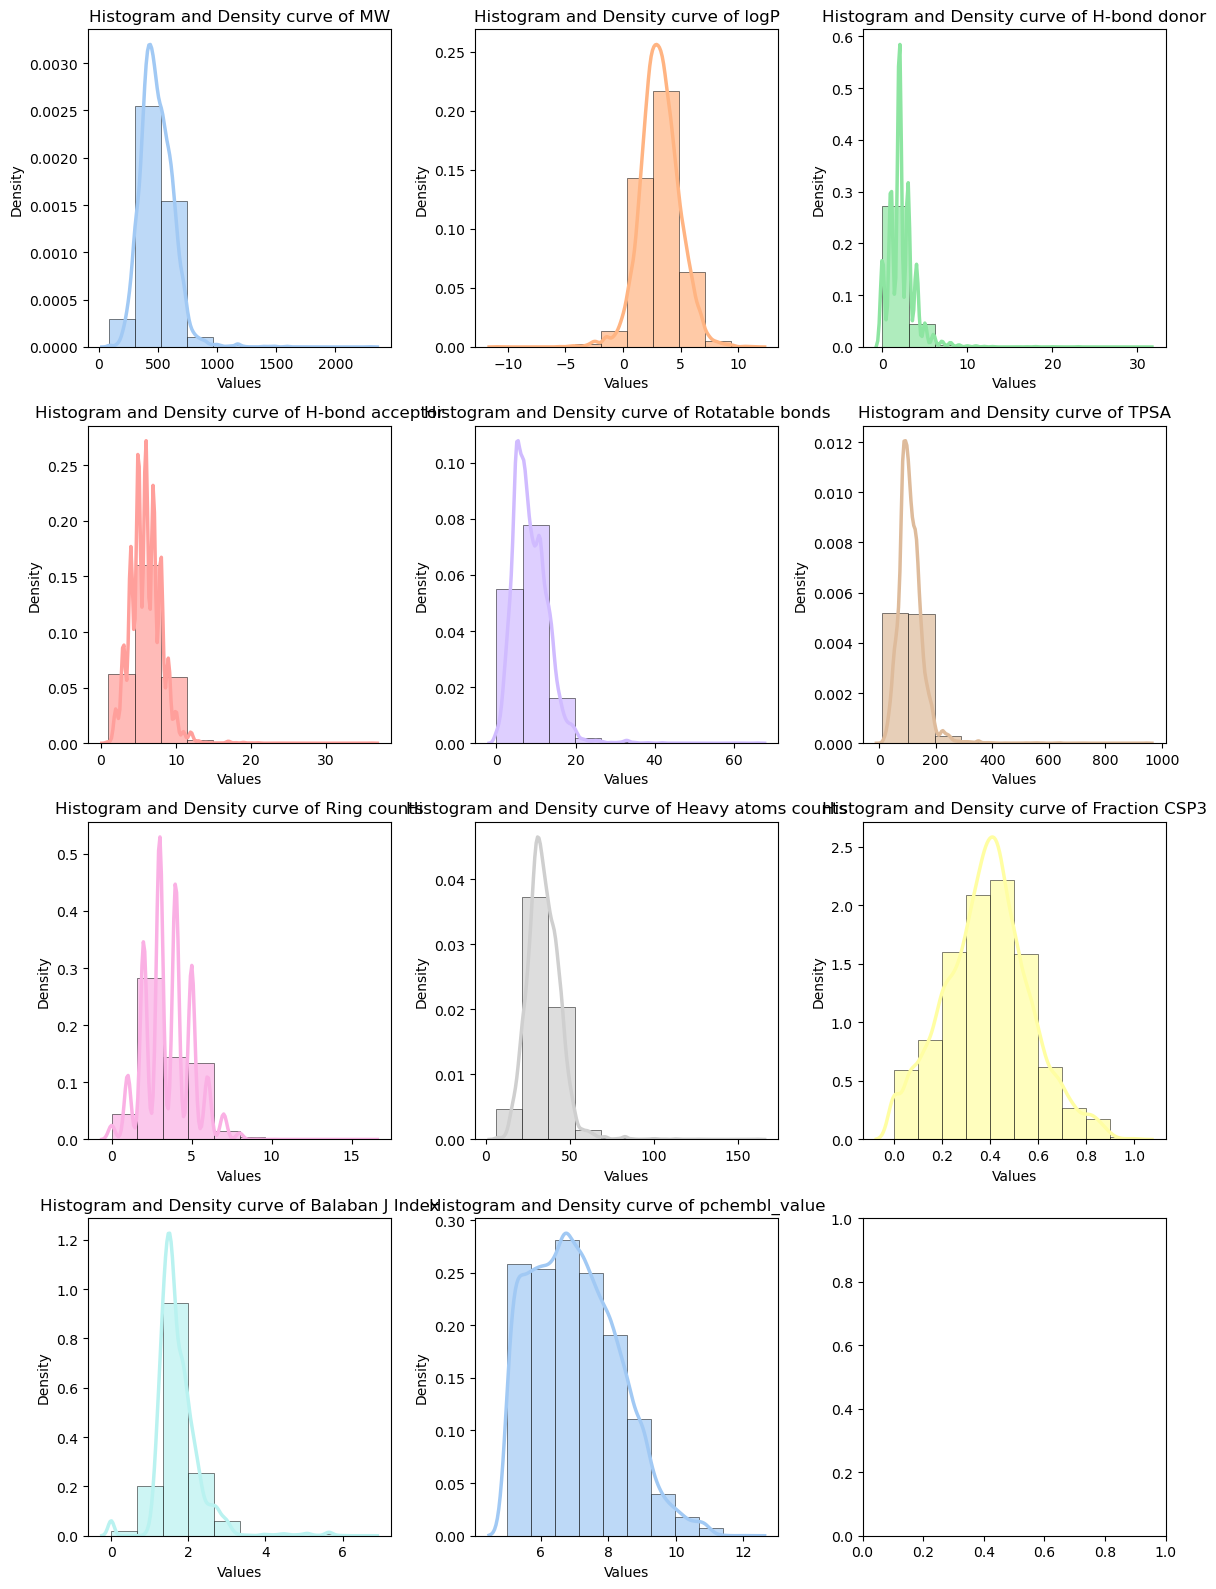

In [23]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

# Numeric columns
col_num = df_final_train_ch.select_dtypes(include='number').columns

# Number of rows and columns needed to create subplots
num_columns = len(col_num)
num_rows = (num_columns + 2) // 3 

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

colors = sns.color_palette('pastel', n_colors=num_columns)

# Histogram with density curve
for i, column in enumerate(col_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(df_final_train_ch[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(df_final_train_ch[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Values')
    axs[row, column_subplot].set_ylabel('Density')
    axs[row, column_subplot].set_title(f'Histogram and Density curve of {column}')


plt.tight_layout()

plt.show()

The data doesn't follow a normal distribution

In [24]:
df_final_train_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19185 entries, 0 to 19184
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Smiles              19185 non-null  object 
 1   MW                  19185 non-null  float64
 2   logP                19185 non-null  float64
 3   H-bond donor        19185 non-null  float64
 4   H-bond acceptor     19185 non-null  float64
 5   Rotatable bonds     19185 non-null  float64
 6   TPSA                19185 non-null  float64
 7   Ring counts         19185 non-null  float64
 8   Heavy atoms counts  19185 non-null  float64
 9   Fraction CSP3       19185 non-null  float64
 10  Balaban J Index     19185 non-null  float64
 11  pchembl_value       19185 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.8+ MB


In [25]:
df_final_train_ch.describe()

MW          logP  H-bond donor  H-bond acceptor  \
count  19185.000000  19185.000000  19185.000000     19185.000000   
mean     490.267317      3.182525      2.273286         6.067970   
std      140.810724      1.707117      1.714144         2.085777   
min       82.106000    -10.910250      0.000000         1.000000   
25%      397.478000      2.137920      1.000000         5.000000   
50%      475.570000      3.127800      2.000000         6.000000   
75%      574.747000      4.227580      3.000000         7.000000   
max     2296.622000     11.564400     31.000000        36.000000   

       Rotatable bonds          TPSA   Ring counts  Heavy atoms counts  \
count     19185.000000  19185.000000  19185.000000        19185.000000   
mean          8.636695    111.579604      3.508991           34.442585   
std           4.490873     46.518381      1.477851            9.888592   
min           0.000000      9.720000      0.000000            6.000000   
25%           5.000000     83.990000      3.000000           28.000000   
50%           8.000000    104.730000      3.000000           34.000000   
75%          11.000000    132.260000      4.000000           40.000000   
max          66.000000    945.470000     16.000000          162.000000   

       Fraction CSP3  Balaban J Index  pchembl_value  
count   19185.000000     1.918500e+04   19185.000000  
mean        0.388349     1.743080e+00       7.008430  
std         0.177603     5.782542e-01       1.264177  
min         0.000000     1.541333e-07       5.000000  
25%         0.269231     1.424171e+00       5.990000  
50%         0.391304     1.621899e+00       6.900000  
75%         0.500000     1.952461e+00       7.890000  
max         1.000000     6.659782e+00      12.100000

Visualització de les dades

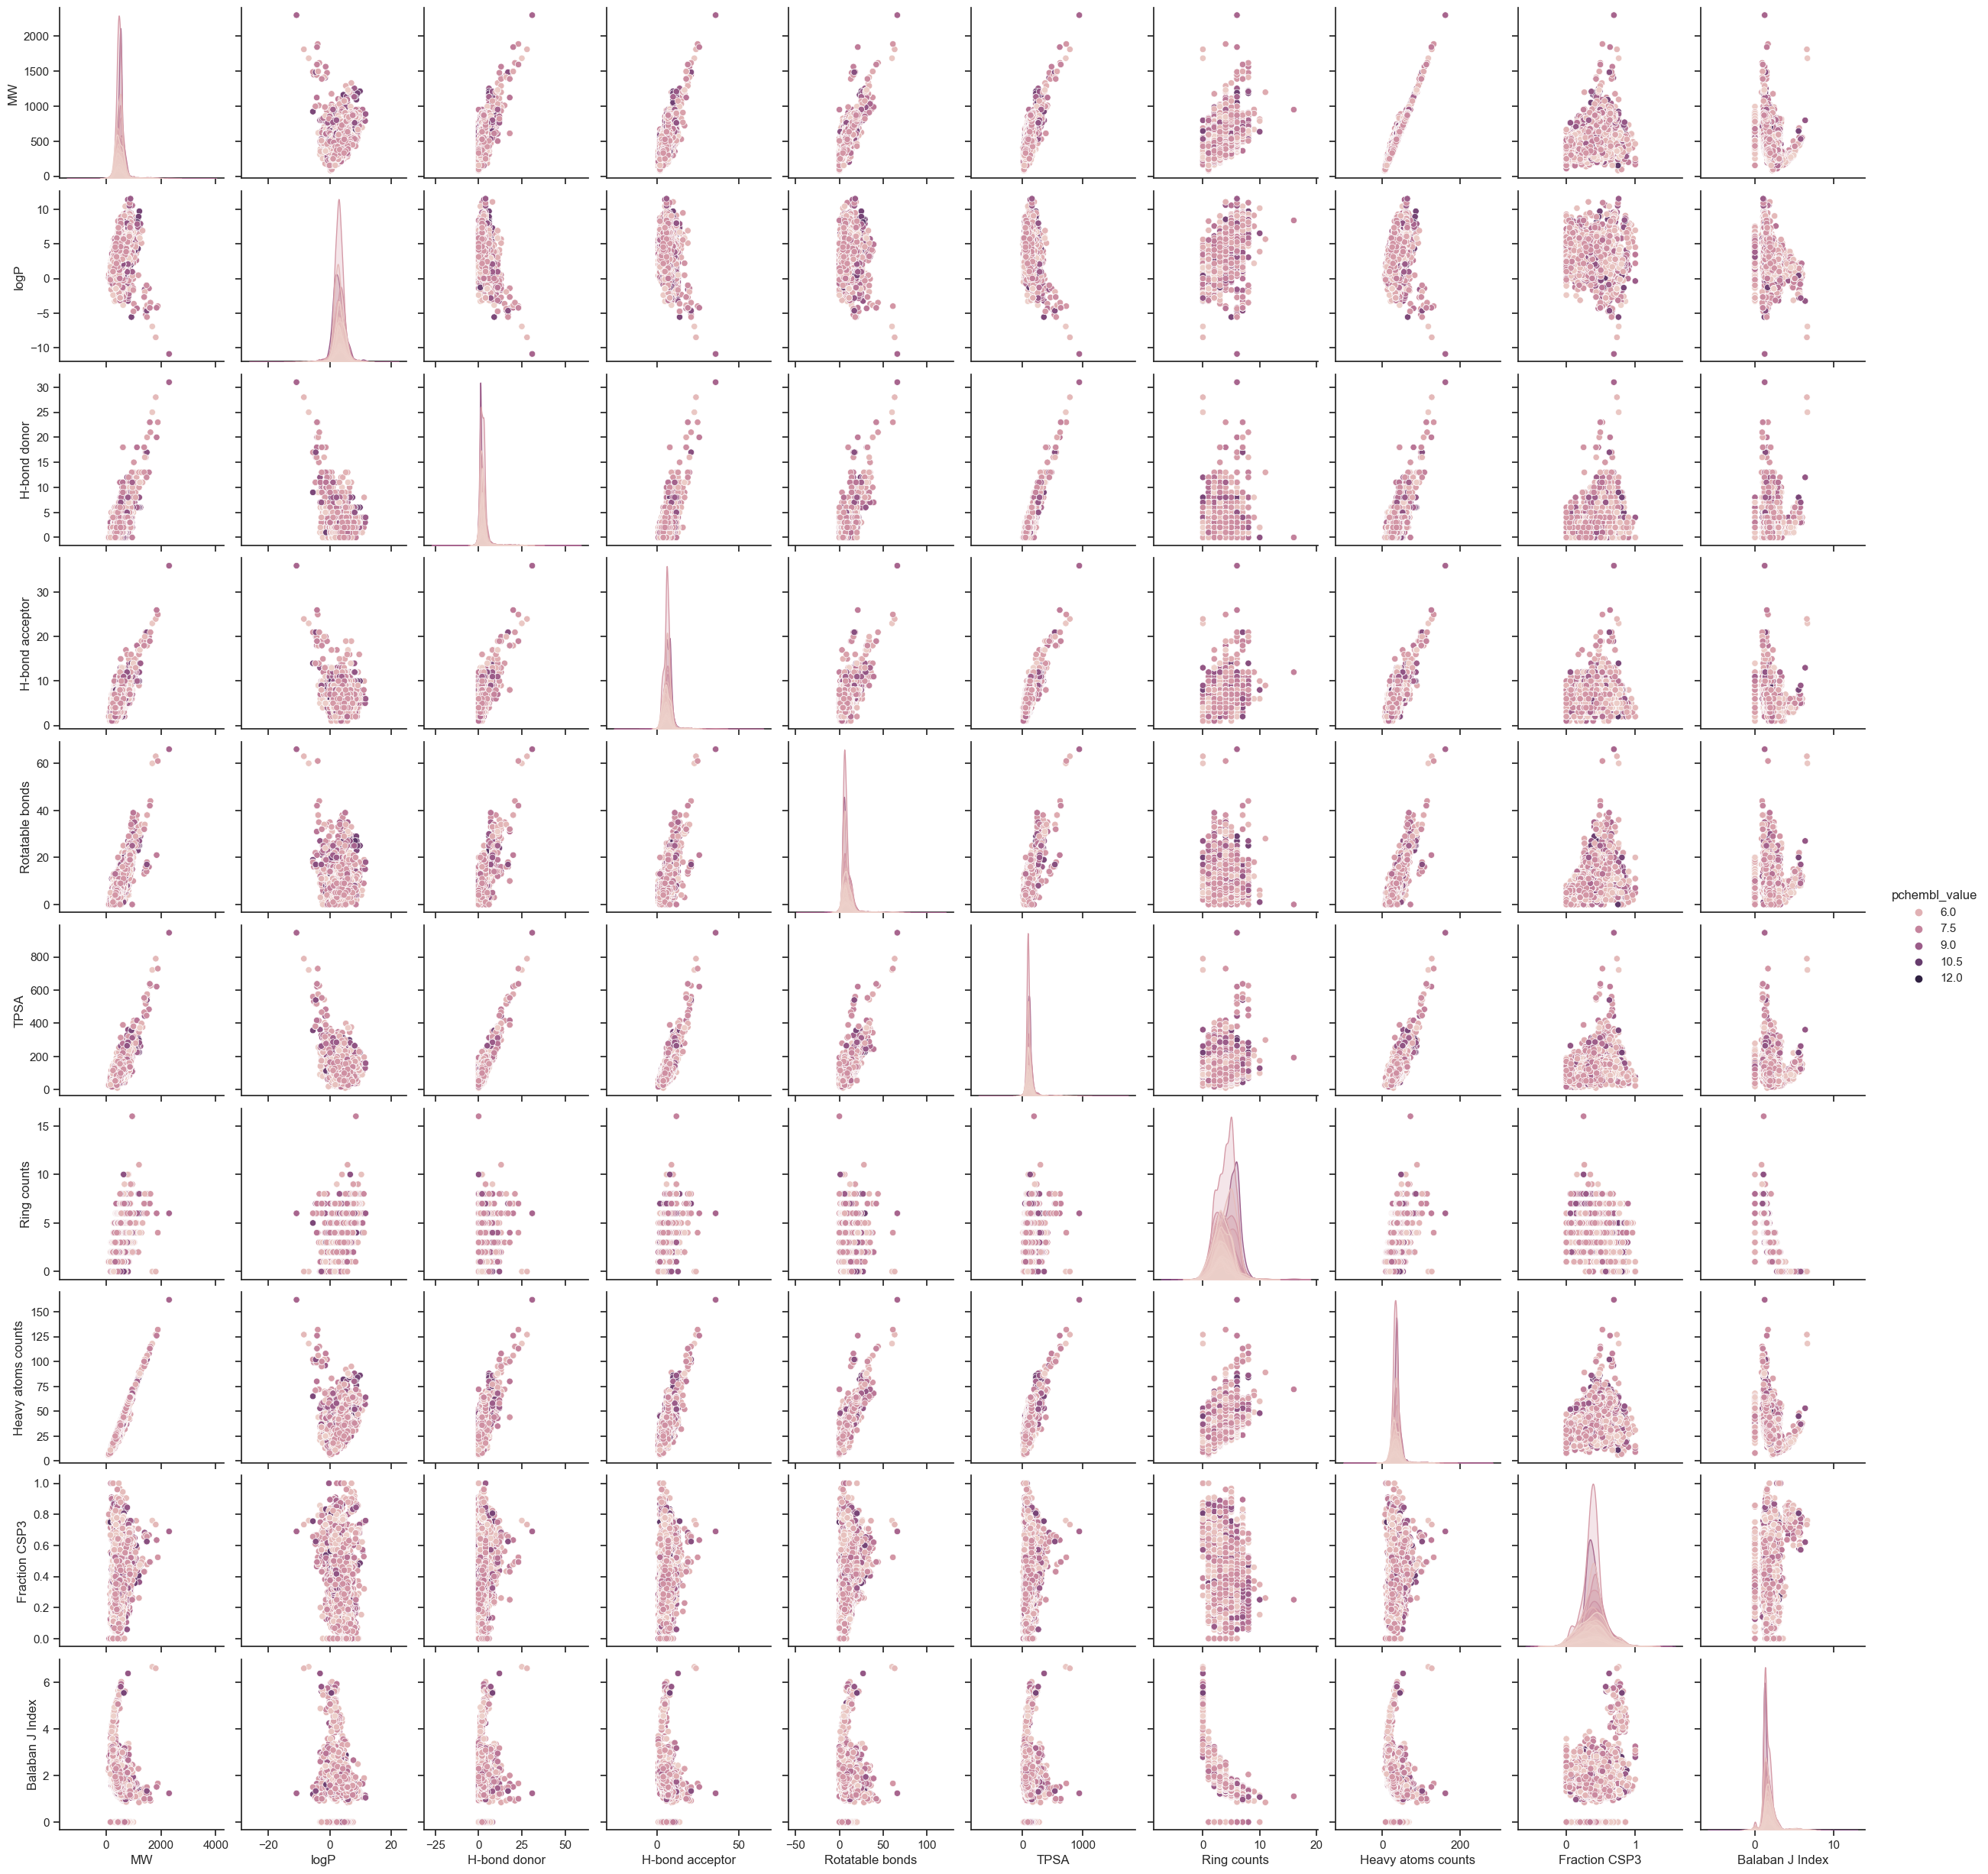

In [26]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

# Plot grid
sns.set(style="ticks")
sns.pairplot(df_final_train_ch, hue='pchembl_value') 
plt.show()


### *FIRST TRAIN*

The first train is the dataframe with the processed data up to this point, and without normalization.

In [27]:
df_cleaned_nonorm = df_final_train_ch.dropna(subset=['Smiles'], axis=0)
# Only the rows with valid SMILES
valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned_nonorm['Smiles']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]

df_save_nonorm = df_cleaned_nonorm[df_cleaned_nonorm['Smiles'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]
df_save_nonorm.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/code/data_chemprop/chemprop_train_nonorm.csv", index=False)

[20:09:04] SMILES Parse Error: syntax error while parsing: nan
[20:09:04] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:04] SMILES Parse Error: syntax error while parsing: nan
[20:09:04] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:04] SMILES Parse Error: syntax error while parsing: nan
[20:09:04] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:05] SMILES Parse Error: syntax error while parsing: nan
[20:09:05] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:05] SMILES Parse Error: syntax error while parsing: nan
[20:09:05] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:05] SMILES Parse Error: syntax error while parsing: nan
[20:09:05] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:05] SMILES Parse Error: syntax error while parsing: nan
[20:09:05] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[20:09:05] SMILES Parse Err

In [29]:
print(df_save_nonorm.shape)

(19172, 12)


### *SECOND TRAIN*

We filter the dataframe and remove the duplicated smiles with lowest pchembl_value.

In [30]:
#import pandas as pd

def filter_highest_pvalue(df):
    duplicated_max_pvalues = df.groupby('Smiles')['pchembl_value'].max()

    filtered_df = df[df.set_index(['Smiles', 'pchembl_value']).index.isin(duplicated_max_pvalues.items())]

    return filtered_df



filtered_df = filter_highest_pvalue(df_final_train_ch)
print(filtered_df.head(20))


                                               Smiles       MW     logP  \
0                    C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  262.165  2.96190   
1   CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  336.435  4.08100   
2      COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  338.407  3.09060   
3   O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  449.485  0.09540   
4   CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  672.828  0.67260   
5            S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1  394.725  4.90930   
6   CC(C)[C@H](NS(=O)(=O)c1ccc(Cl)cc1)C(=O)N[C@@H]...  461.971  3.05060   
7     CS[C@@H]1C(=O)N(C(=O)NCc2ccncc2)[C@H]1Cc1ccccc1  341.436  2.47630   
8   CC(C)CC[C@H](NS(=O)(=O)c1ccc(F)cc1)C(=O)N[C@@H...  400.516  2.63860   
9   CC(C)C[C@H](C=O)NC(=O)[C@@H](NS(=O)(=O)c1ccc(C...  388.917  2.37270   
10         C[C@@H](NC(=O)N1C(=O)CC1Sc1ccccc1)c1ccccc1  326.421  3.80790   
11              N/C(S)=N/N=C/c1cccn1S(=O)(=O)c1ccccc1  308.388  1.30350   
12                  CC/C(

In [31]:
df_cleaned_nonorm_filtered = filtered_df.dropna(subset=['Smiles'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned_nonorm_filtered['Smiles']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]


df_nonorm_filtered = df_cleaned_nonorm_filtered[df_cleaned_nonorm_filtered['Smiles'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]
print(df_nonorm_filtered.head(20))

[20:12:40] SMILES Parse Error: syntax error while parsing: nan
[20:12:40] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'


                                               Smiles       MW     logP  \
0                    C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  262.165  2.96190   
1   CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  336.435  4.08100   
2      COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  338.407  3.09060   
3   O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  449.485  0.09540   
4   CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  672.828  0.67260   
5            S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1  394.725  4.90930   
6   CC(C)[C@H](NS(=O)(=O)c1ccc(Cl)cc1)C(=O)N[C@@H]...  461.971  3.05060   
7     CS[C@@H]1C(=O)N(C(=O)NCc2ccncc2)[C@H]1Cc1ccccc1  341.436  2.47630   
8   CC(C)CC[C@H](NS(=O)(=O)c1ccc(F)cc1)C(=O)N[C@@H...  400.516  2.63860   
9   CC(C)C[C@H](C=O)NC(=O)[C@@H](NS(=O)(=O)c1ccc(C...  388.917  2.37270   
10         C[C@@H](NC(=O)N1C(=O)CC1Sc1ccccc1)c1ccccc1  326.421  3.80790   
11              N/C(S)=N/N=C/c1cccn1S(=O)(=O)c1ccccc1  308.388  1.30350   
12                  CC/C(

In [32]:
print(df_nonorm_filtered.shape)

(11703, 12)


In [33]:
#import pandas as pd

df_nonorm_filtered.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/code/data_chemprop/chemprop_train_nonorm_filtered.csv", index=False)

### *THIRD TRAIN

Normalization data with Z-Score. 
EXPLICACIO Z-SCORE

In [35]:
#import pandas as pd

smiles_column = df_nonorm_filtered['Smiles']
norm_zscore_df = df_nonorm_filtered.drop(columns=['Smiles']).copy()

def z_score_normalization(column):
    mean = column.mean()
    std = column.std()
    return (column - mean) / std

norm_zscore_df = norm_zscore_df.apply(z_score_normalization)

norm_zscore_df.insert(0, 'Smiles', smiles_column)

print("Original dataframe:")
print(df_final_train_ch)

print("\nZ-Score normalized dataframe:")
print(norm_zscore_df)


Original dataframe:
                                                  Smiles       MW     logP  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  262.165  2.96190   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  336.435  4.08100   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  338.407  3.09060   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  449.485  0.09540   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  672.828  0.67260   
...                                                  ...      ...      ...   
19180  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2C...  525.568  4.62928   
19181  Fc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1  359.271  4.16348   
19182  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2B...  378.524  3.15278   
19183  Cc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)F)c1  356.473  5.06798   
19184  COc1cnc(Nc2ccc(-c3ccsc3)cn2)nc1Nc1cccc(C(F)(F)...  330.435  4.55418   

       H-bond donor  H-bond acceptor  Rotat

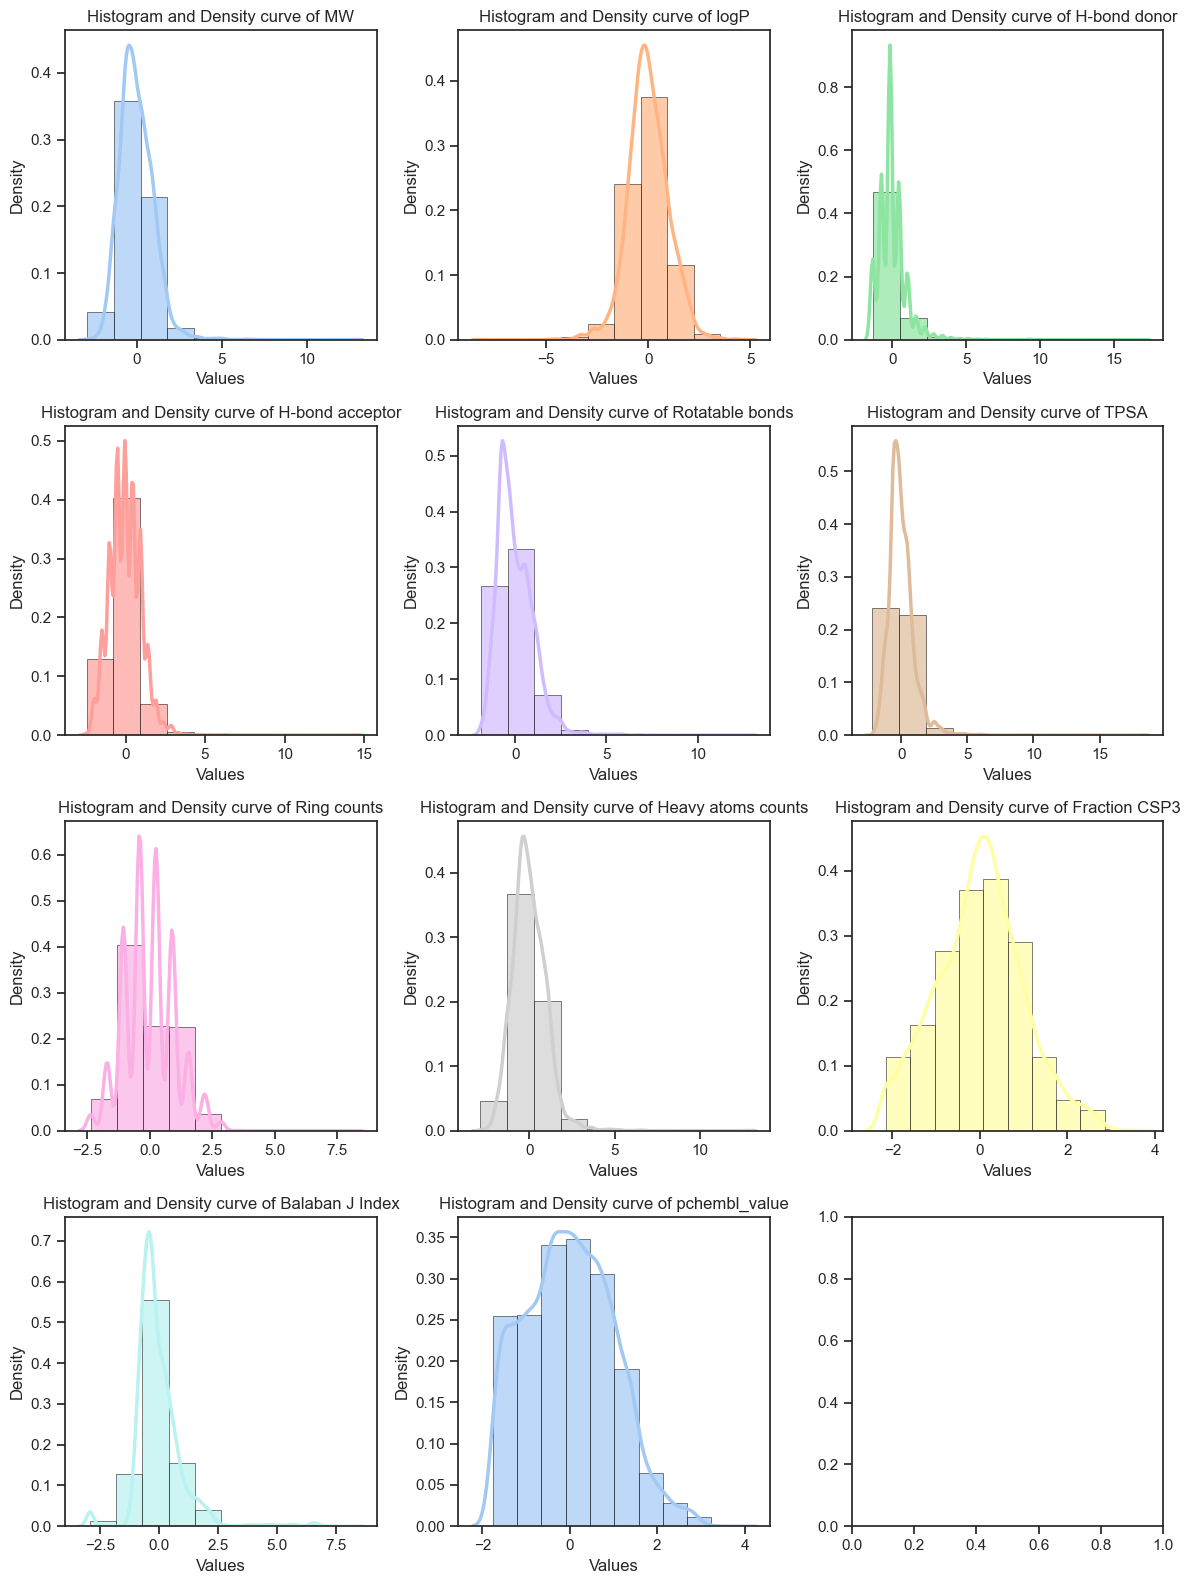

In [40]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns


col_num = norm_zscore_df.select_dtypes(include='number').columns

num_columns = len(col_num)
num_rows = (num_columns + 2) // 3  

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

colors = sns.color_palette('pastel', n_colors=num_columns)

for i, column in enumerate(col_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(norm_zscore_df[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(norm_zscore_df[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Values')
    axs[row, column_subplot].set_ylabel('Density')
    axs[row, column_subplot].set_title(f'Histogram and Density curve of {column}')


plt.tight_layout()

plt.show()

In [37]:
df_cleaned_zs = norm_zscore_df.dropna(subset=['Smiles'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned_zs['Smiles']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]

df_save_zs = df_cleaned_zs[df_cleaned_zs['Smiles'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]

In [38]:
#import pandas as pd

df_save_zs.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/code/data_chemprop/chemprop_train_normzs.csv", index=False)

### *FOURTH TRAIN*

Data normalized with MinMaxScaler.

EXPLICAR

In [39]:

#from sklearn.preprocessing import MinMaxScaler

smiles_column = df_nonorm_filtered['Smiles']

df_normalized = df_nonorm_filtered.drop(columns=['Smiles']).copy()

scaler = MinMaxScaler()


df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)


df_normalized.insert(0, 'Smiles', smiles_column)

print(df_normalized)


                                                  Smiles        MW      logP  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  0.081309  0.617235   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  0.114846  0.667029   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  0.115737  0.622962   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  0.165896  0.489692   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  0.266750  0.515374   
...                                                  ...       ...       ...   
19162  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)nn3)ncc2C...  0.160226  0.739026   
19164  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4cccs4)cn3)ncc2C...  0.137640  0.670589   
19168  FC(F)(F)Oc1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2...  0.140132  0.611620   
19169        Fc1ccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2Cl)cc1  0.098494  0.552518   
19176  CC(=O)Nc1ccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2Cl)cc1  0.138004  0.746314   

       H-bond donor  H-bond acceptor  R

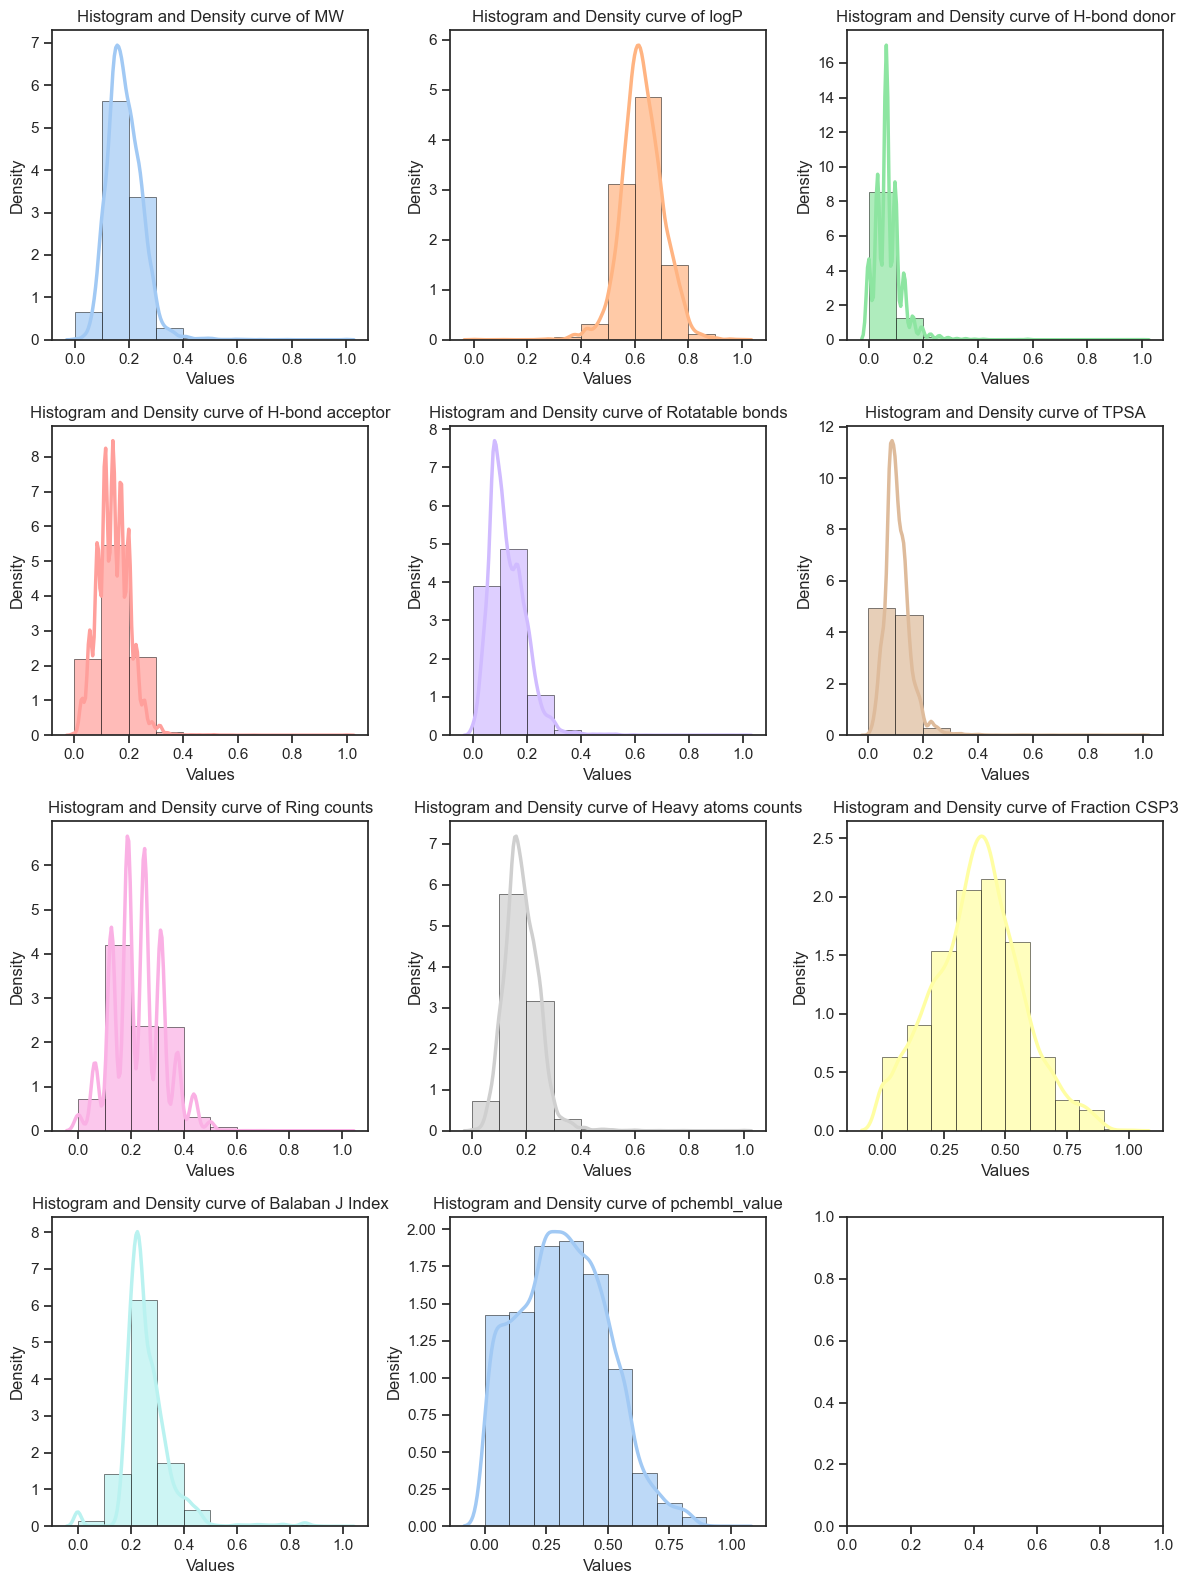

In [41]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns


col_num = df_normalized.select_dtypes(include='number').columns

num_columns = len(col_num)
num_rows = (num_columns + 2) // 3  

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

colors = sns.color_palette('pastel', n_colors=num_columns)

for i, column in enumerate(col_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(df_normalized[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(df_normalized[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Values')
    axs[row, column_subplot].set_ylabel('Density')
    axs[row, column_subplot].set_title(f'Histogram and Density curve of {column}')


plt.tight_layout()

plt.show()

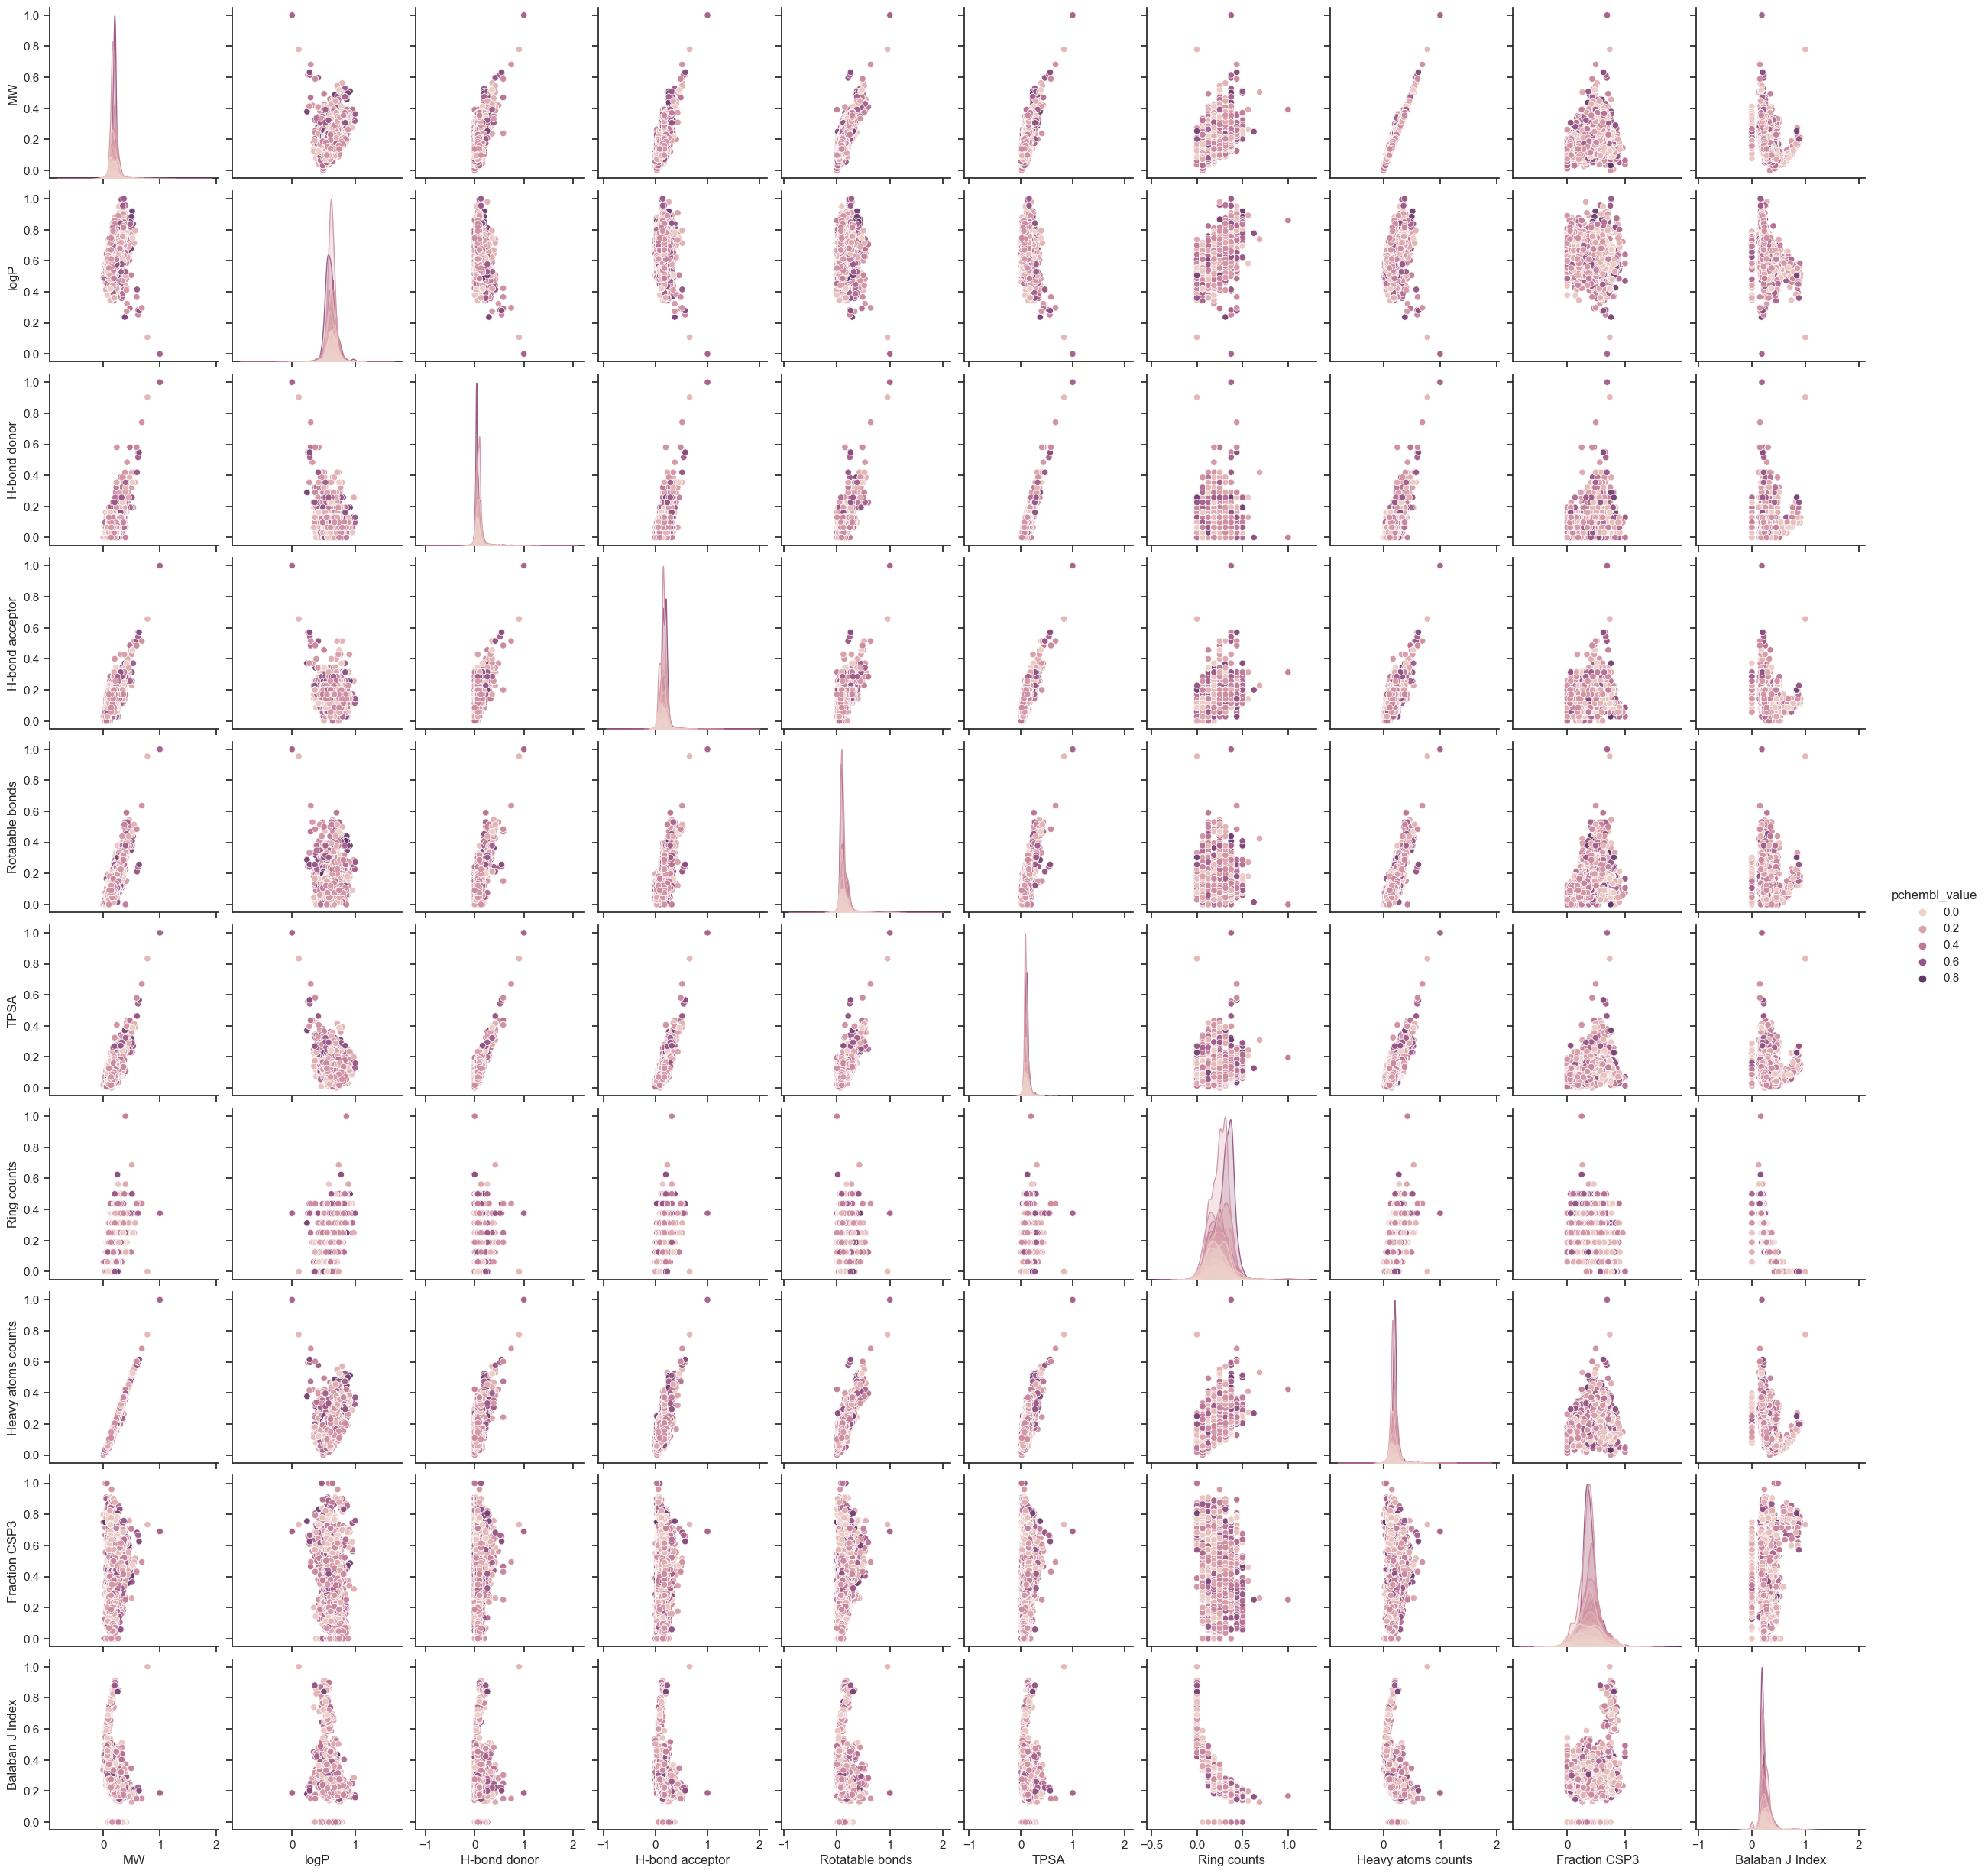

In [42]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt


sns.set(style="ticks")
sns.pairplot(df_normalized, hue='pchembl_value')
plt.show()

In [43]:

df_cleaned = df_normalized.dropna(subset=['Smiles'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned['Smiles']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]

df_save = df_cleaned[df_cleaned['Smiles'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]
print(df_save)


                                                  Smiles        MW      logP  \
0                       C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1  0.081309  0.617235   
1      CCC[C@@H](NC(=O)N1C(=O)C[C@@H]1Cc1ccccc1)c1ccccc1  0.114846  0.667029   
2         COc1ccc(CN(C)C(=O)N2C(=O)C[C@@H]2Cc2ccccc2)cc1  0.115737  0.622962   
3      O=C1C[C@H](NC(=O)[C@@H]2CS[C@H]3CC[C@H](NC(=O)...  0.165896  0.489692   
4      CC[C@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)[C@@H](NC(...  0.266750  0.515374   
...                                                  ...       ...       ...   
19162  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4ccsc4)nn3)ncc2C...  0.160226  0.739026   
19164  FC(F)(F)c1cccc(Nc2nc(Nc3ccc(-c4cccs4)cn3)ncc2C...  0.137640  0.670589   
19168  FC(F)(F)Oc1cccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2...  0.140132  0.611620   
19169        Fc1ccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2Cl)cc1  0.098494  0.552518   
19176  CC(=O)Nc1ccc(Nc2nc(Nc3ccc(-c4ccsc4)cn3)ncc2Cl)cc1  0.138004  0.746314   

       H-bond donor  H-bond acceptor  R

In [44]:
#import pandas as pd

df_save.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/code/data_chemprop/chemprop_train_norm_mms1.csv", index=False)


## BEST TRAIN DATA ANALYSIS 

We perform a data analysis of the train with best result. First of all, we do a data filtration to keep only the molecules with pchembl_value equal or higher than 0,5.

In [46]:
#import pandas as pd

def filter_mol_to_pvalue(df, threshold=6.5):
    df_threshold = df[df['pchembl_value'] >= threshold]
    return df_threshold

# Llamar a la función para filtrar las moléculas
df_filt_pvalue = filter_mol_to_pvalue(df_save, threshold=0.5)

print(df_filt_pvalue)

                                                  Smiles        MW      logP  \
20     CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(...  0.189825  0.361142   
111    N#C[C@@H](NC(=O)[C@H](CC1CCCCC1)NC(=O)N1CCOCC1...  0.142876  0.607730   
117    CC(C)(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)...  0.151011  0.577025   
119    N#C[C@H](COCc1ccccc1Cl)NC(=O)[C@H](CC1CCCCC1)N...  0.178323  0.629867   
124    CC(C)C[C@H](NC(=O)N1CCOCC1)C(=O)N[C@H](C#N)COC...  0.144677  0.559667   
...                                                  ...       ...       ...   
19101  COC1=CC(=O)N(C(=O)/C=C/[C@H](CCc2ccccc2)NC(=O)...  0.160226  0.739026   
19102  COC1=CC(=O)N(C(=O)/C=C/[C@@H](CCc2ccccc2)NC(=O...  0.160226  0.739026   
19103  COC1=CC(=O)N(C(=O)/C=C/[C@H](CCc2ccccc2)NC(=O)...  0.134909  0.713958   
19104  COC1=CC(=O)N(C(=O)/C=C/[C@@H](CCc2ccccc2)NC(=O...  0.137640  0.670589   
19105  COC1=CC(=O)N(C(=O)/C=C/[C@H](CCc2ccccc2)NC(=O)...  0.172403  0.698256   

       H-bond donor  H-bond acceptor  R

The result is a dataframe with 1,980 molecules.

In [47]:
df_filt_pvalue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 20 to 19105
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Smiles              1908 non-null   object 
 1   MW                  1908 non-null   float64
 2   logP                1908 non-null   float64
 3   H-bond donor        1908 non-null   float64
 4   H-bond acceptor     1908 non-null   float64
 5   Rotatable bonds     1908 non-null   float64
 6   TPSA                1908 non-null   float64
 7   Ring counts         1908 non-null   float64
 8   Heavy atoms counts  1908 non-null   float64
 9   Fraction CSP3       1908 non-null   float64
 10  Balaban J Index     1908 non-null   float64
 11  pchembl_value       1908 non-null   float64
dtypes: float64(11), object(1)
memory usage: 193.8+ KB


In [48]:

# Get only numerical columns
numerical_columns = \
list(df_filt_pvalue.dtypes[df_filt_pvalue.dtypes == 'float64'].index)

len(numerical_columns)

11

In [50]:
sig_res_filt_num = df_filt_pvalue.copy()
sig_res_filt_num = sig_res_filt_num.drop("Smiles", axis=1)

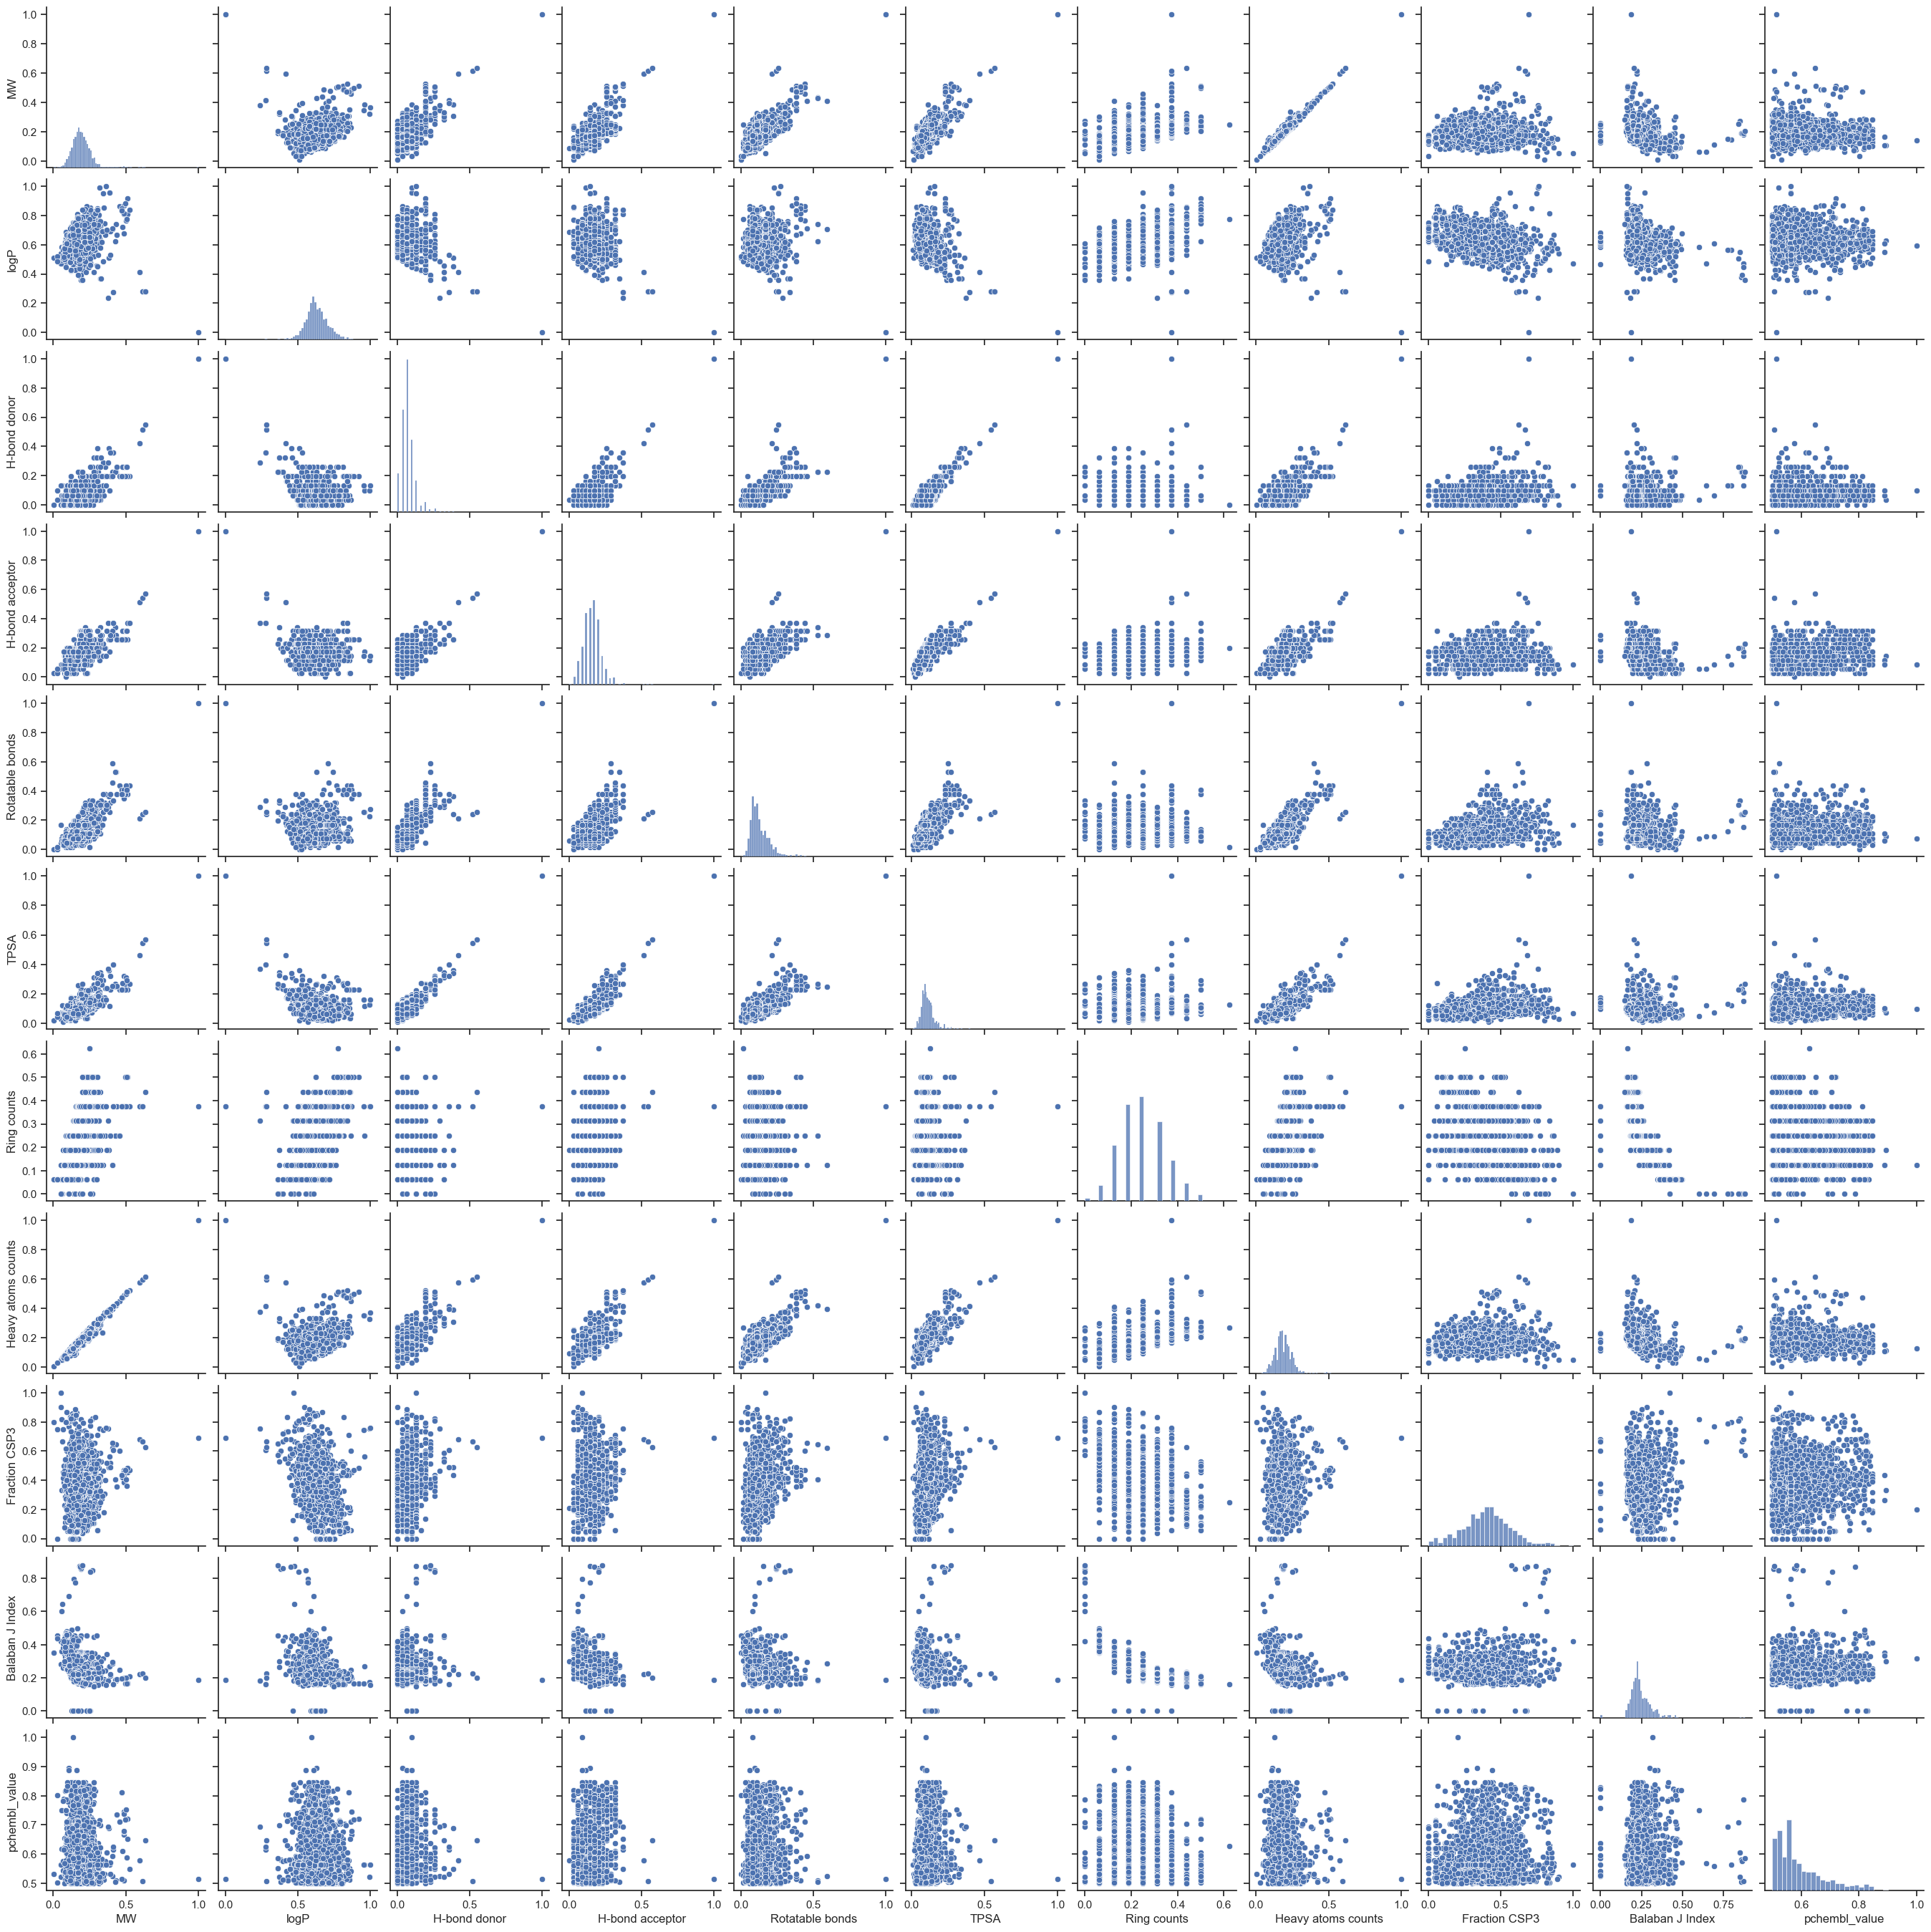

In [58]:
sns.pairplot(sig_res_filt_num)
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/pairplot_matrix_train4.png')
plt.show()

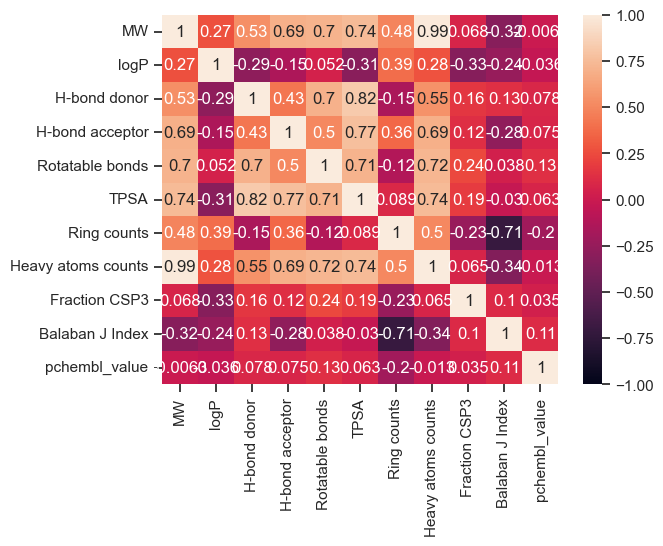

In [59]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

sns.heatmap(sig_res_filt_num.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/heatmap_train4.png')

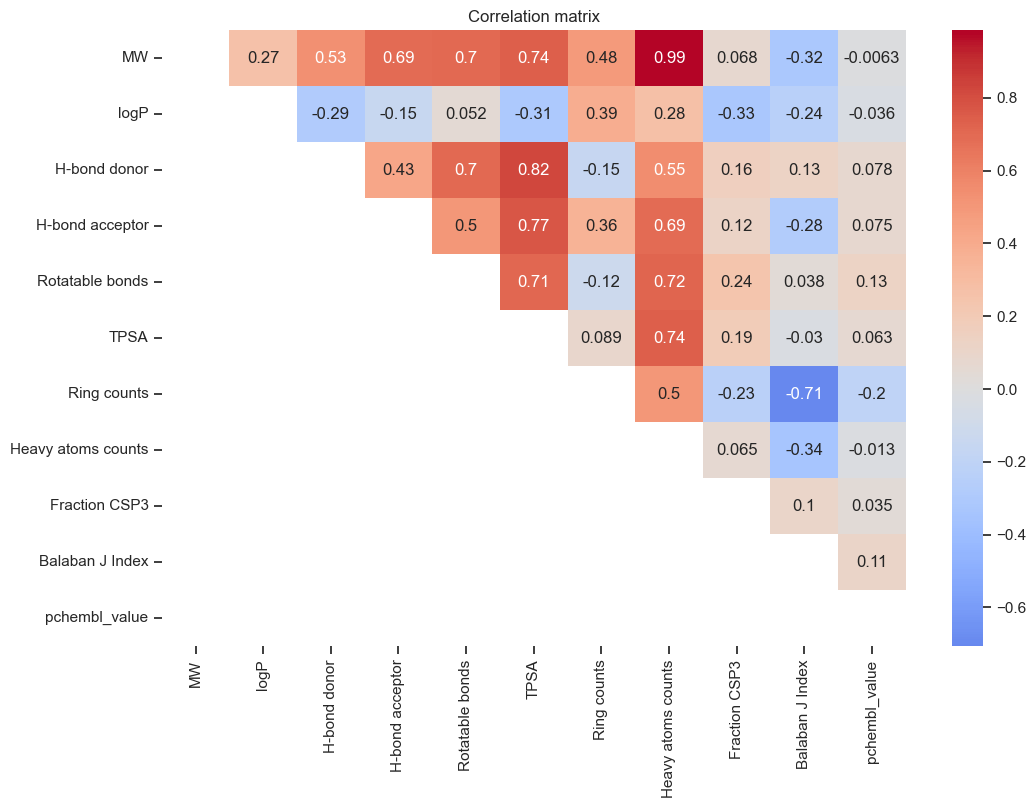

In [60]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
#import numpy as np

correlation_matrix = sig_res_filt_num.corr()


mask = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

plt.figure(figsize=(12, 8))

sns.heatmap(mask, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation matrix')
plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/migheatmap_train4.png')
plt.show()

Text(0.5, 1.0, 'Correlation with pchembl_value')

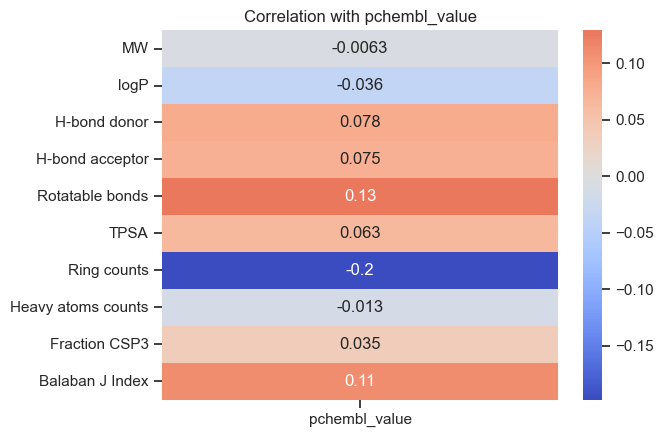

In [61]:
pchembl_corr = correlation_matrix['pchembl_value'].drop('pchembl_value')
sns.heatmap(pchembl_corr.to_frame(), annot=True, cmap='coolwarm', center=0)

plt.savefig('/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/cor_plot3_pchembl_train4.png')
plt.title('Correlation with pchembl_value')